In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 167304040


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 167304040

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 31 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 01 2018 TESS-SPOC    1800   167304040      0.0         N/A
  1 TESS Sector 02 2018 TESS-SPOC    1800   167304040      0.0         N/A
  2 TESS Sector 03 2018 TESS-SPOC    1800   167304040      0.0         N/A
  3 TESS Sector 04 2018 TESS-SPOC    1800   167304040      0.0         N/A
  4 TESS Sector 05 2018 TESS-SPOC    1800   167304040      0.0         N/A
  5 TESS Sector 06 2018 TESS-SPOC    1800   167304040      0.0         N/A
  6 TESS Sector 08 2019 TESS-SPOC    1800   167304040      0.0         N/A
  7 TESS Sector 09 2019      SPOC     120   167304040      0.0         N/A
  8 TESS Sector 10 2019      SPOC     120   167304040      0.0         N/A
  9 TESS Sector 11 2019      SPOC     120   167304040      0.0         N/A
 10 TESS Sector 12 2019      SPOC     120   167304040      0.0         N/A
 11 TESS Sector 13 2019      SPOC     120   167304040      0.0         N/A
 12 TESS Sector 28 2020 TESS-SPOC     600   167304040      0.0         N/A
 13 TESS Sector 29 2020 TESS-SPOC     600   167304040      0.0         N/A
 14 TESS Sector 30 2020 TESS-SPOC     600   167304040      0.0         N/A
 15 TESS Sector 31 2020 TESS-SPOC     600   167304040      0.0         N/A
 16 TESS Sector 32 2020 TESS-SPOC     600   167304040      0.0         N/A
 17 TESS Sector 33 2020 TESS-SPOC     600   167304040      0.0         N/A
 18 TESS Sector 34 2021 TESS-SPOC     600   167304040      0.0         N/A
 19 TESS Sector 35 2021 TESS-SPOC     600   167304040      0.0         N/A
 20 TESS Sector 36 2021 TESS-SPOC     600   167304040      0.0         N/A
 21 TESS Sector 38 2021 TESS-SPOC     600   167304040      0.0         N/A
 22 TESS Sector 39 2021 TESS-SPOC     600   167304040      0.0         N/A
 23 TESS Sector 61 2023      SPOC     120   167304040      0.0      G05003
 24 TESS Sector 62 2023      SPOC     120   167304040      0.0      G05003
 25 TESS Sector 63 2023      SPOC     120   167304040      0.0      G05003
 26 TESS Sector 64 2023      SPOC     120   167304040      0.0      G05003
 27 TESS Sector 65 2023      SPOC     120   167304040      0.0      G05003
 28 TESS Sector 66 2023      SPOC     120   167304040      0.0      G05003
 29 TESS Sector 67 2023      SPOC     120   167304040      0.0      G05003
 30 TESS Sector 69 2023      SPOC     120   167304040      0.0      G05003

285292

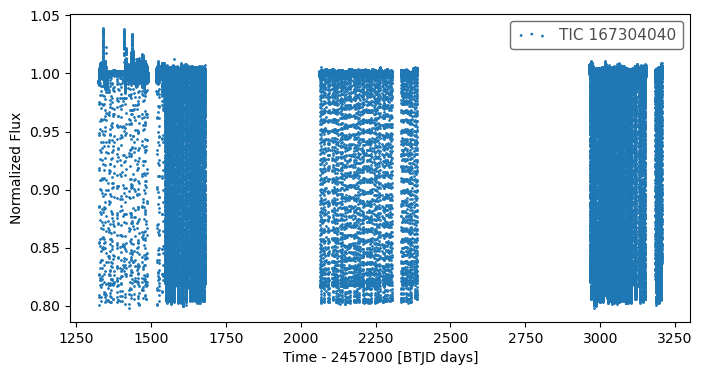

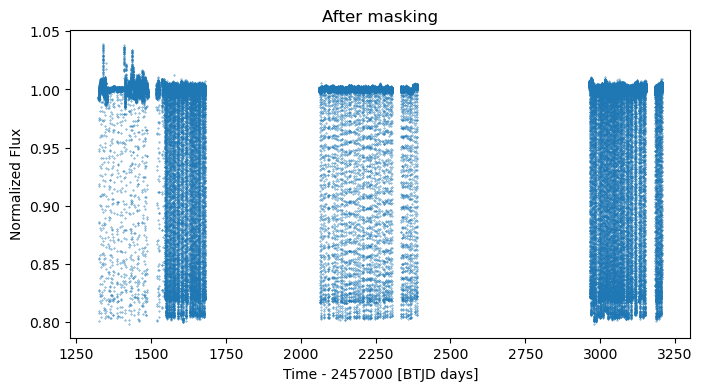

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data
# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) )
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [8]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

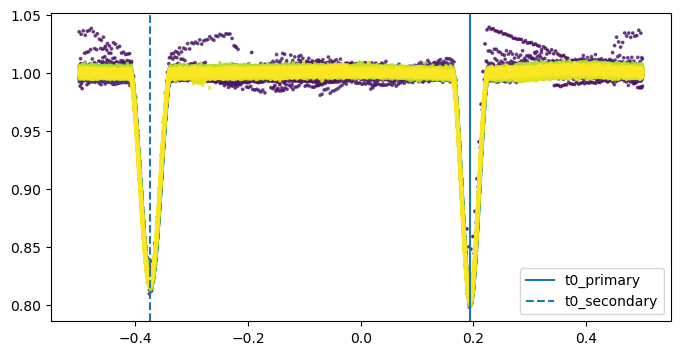

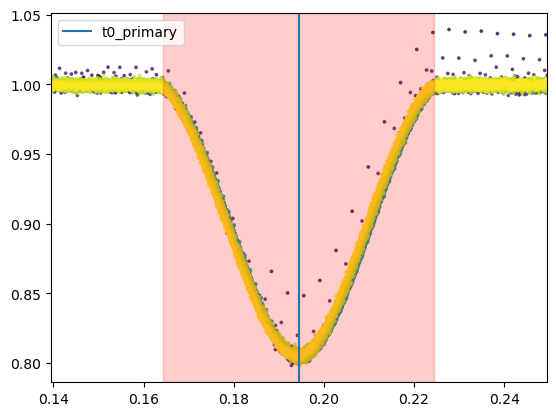

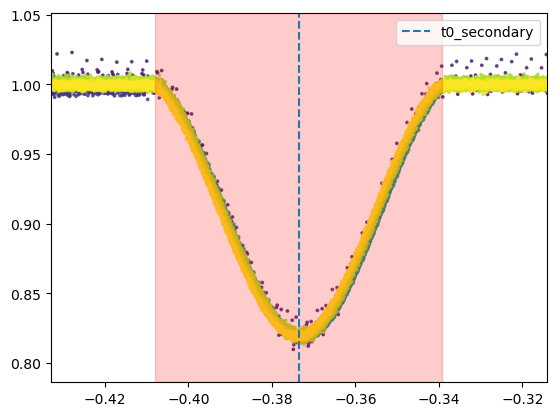

In [10]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0

# epoch=1543.381, duration_hr=8.37838, period=5.819090205174259, label="s0001s0069tce1", transit_depth_percent=18.7626,  # period_err=1.8e-7
# epoch=1545.9, duration_hr=9.60653, period=5.81908, label="s0001s0069tce2", transit_depth_percent=17.8863,
# VSX: 5.8191
# MCMC on df_primary: 5.819093121639943, err=5e-8, t0=1328.0753977905329, err=9e-6


# FILL-IN THE eclipse epoch / period,
# period = 5.81909  # TCE1
period = 5.8190931  # MCMC


t0_primary = 1543.381
t0_secondary = t0_primary + 2.514

duration_hr_primary = 8.38
duration_hr_secondary = 9.61

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [11]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.8 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.0, -0.196, midpoint_p, 0.015, 0.9]
start_vals_s = [1.0, -0.182, midpoint_s, 0.016, 1.01]


# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, t0_primary, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1328.0745553000002 0.19441173745785412
window_width_p (phase): 0.04800289813774132
Secondary: 1330.5885553 -0.3735621793024919
window_width_s (phase): 0.055048669582779715


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.0, -0.196, t0_primary, 0.015, 0.9, 5.8190931],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [07:53<00:00,  2.11it/s]


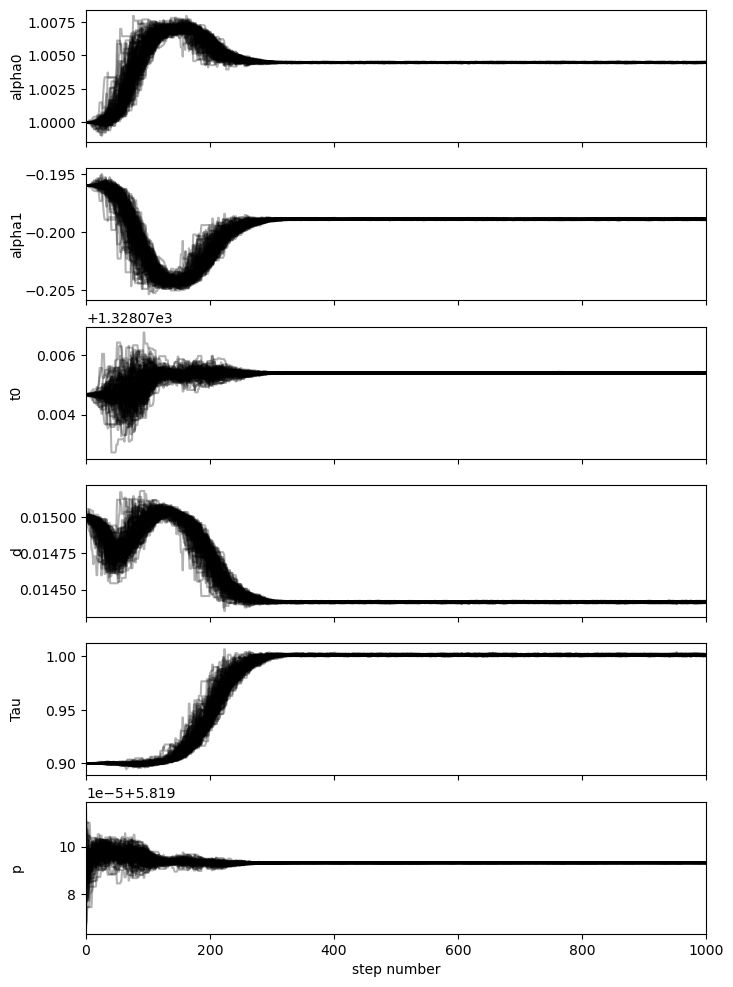

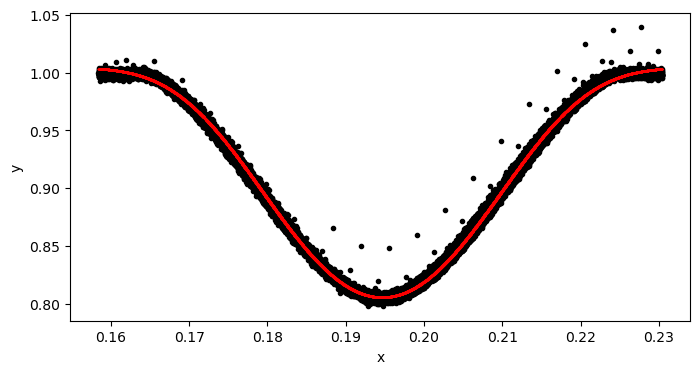

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0044717622026984, -0.19889703993523167, 1328.0753977905329, 0.014412985744920916, 1.0014027241200911, 5.819093121639943
std_p: 5.041795399114098e-08 ; std_t0: 9.058486249744149e-06


In [10]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0044717622026984, -0.19889703993523167, 1328.0753977905329, 0.014412985744920916, 1.0014027241200911, 5.819093121639943
    # std_p: 5.041795399114098e-08 ; std_t0: 9.058486249744149e-06
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.196, t0_primary, 0.015, 0.9, 5.81909],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=1000, discard=600,
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.73it/s]


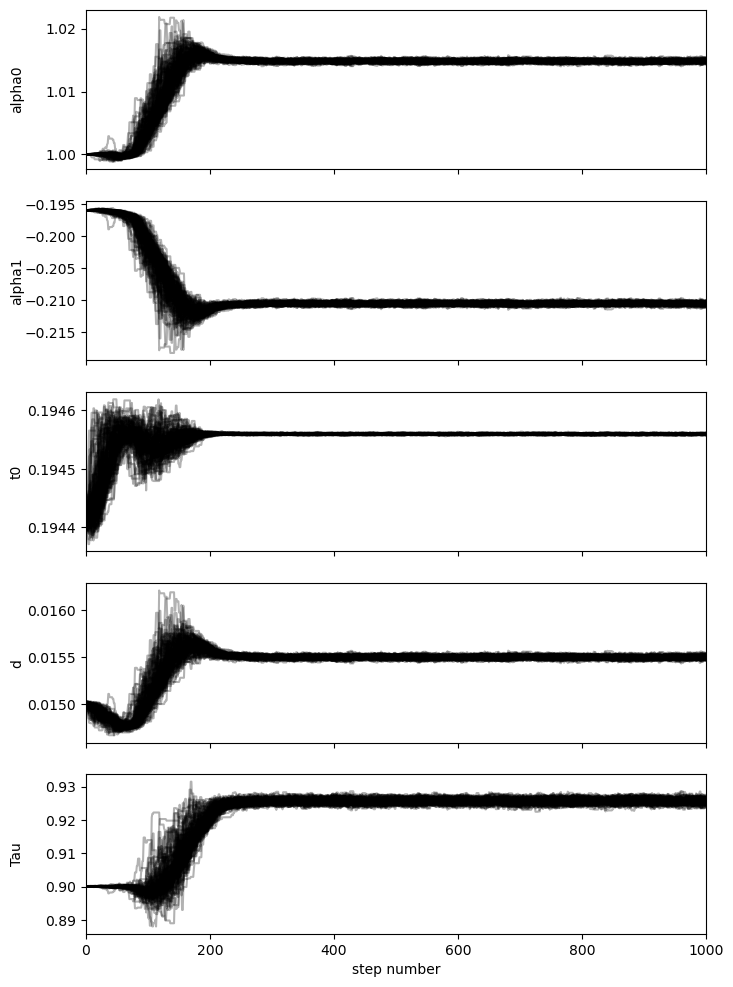

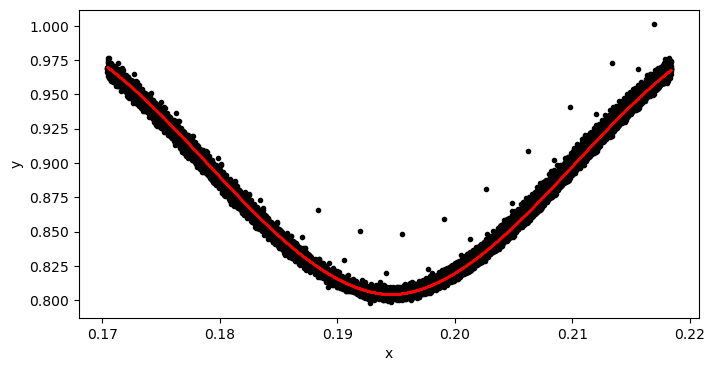

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.87it/s]


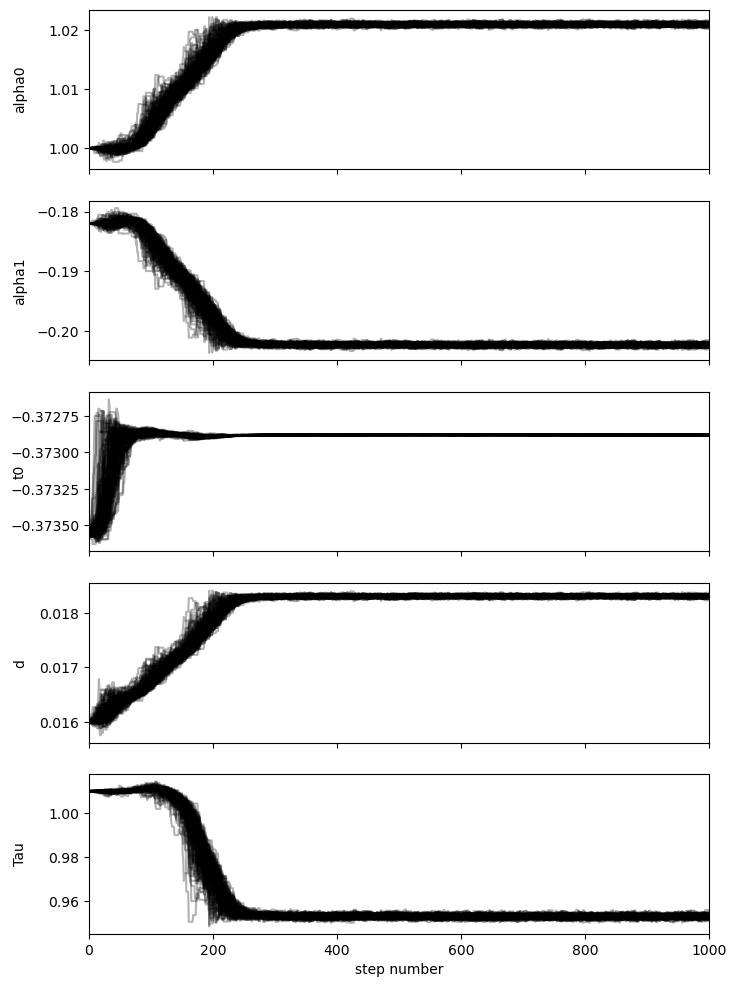

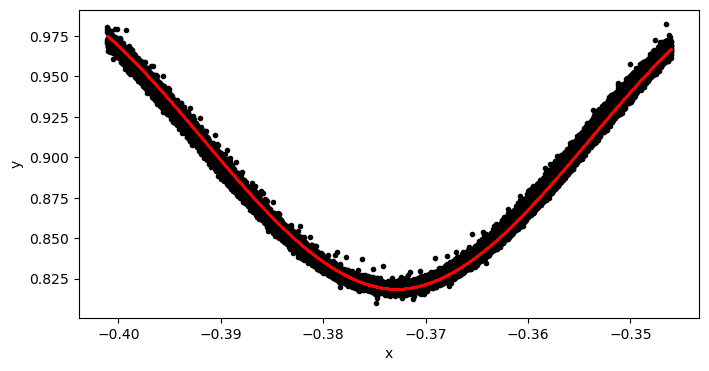

In [12]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data, inlcuding ingress/egress
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0044557867289143, -0.198877686264882, 0.1945571013493341, 0.014411145226573309, 1.001573958805341
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0047499938961493, -0.18459083954613942, -0.37288288299787453, 0.016458382389175366, 1.0604148968804399

    # initial fit params from TESS data, without ingress/egress
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.014826475078101, -0.21053037767239002, 0.19455958198552775, 0.015496481143891908, 0.9257338358964804
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0210124287264306, -0.2023593160141779, -0.3728793304160709, 0.018308159182673586, 0.9530297968900197


    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [14]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.014826475078101, -0.21053037767239002, 0.19455958198552775, 0.015496481143891908, 0.9257338358964804
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0210124287264306, -0.2023593160141779, -0.3728793304160709, 0.018308159182673586, 0.9530297968900197


322

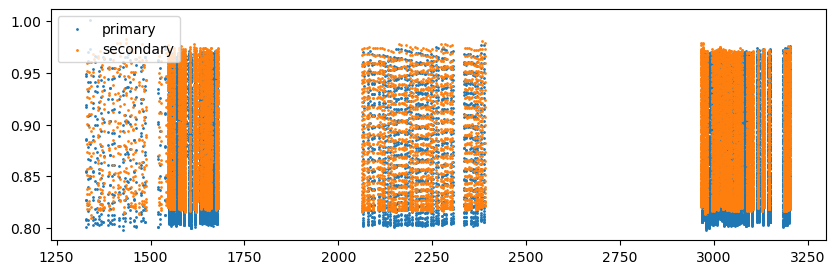

In [15]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1328.0745553000002 5.8190931 1328.0745553000002


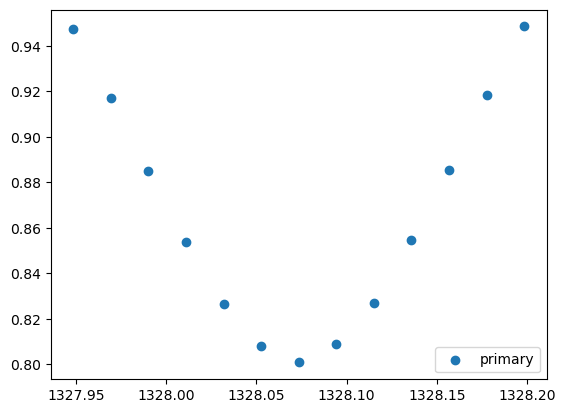

1328.0745553000002 5.8190931 1333.8936484


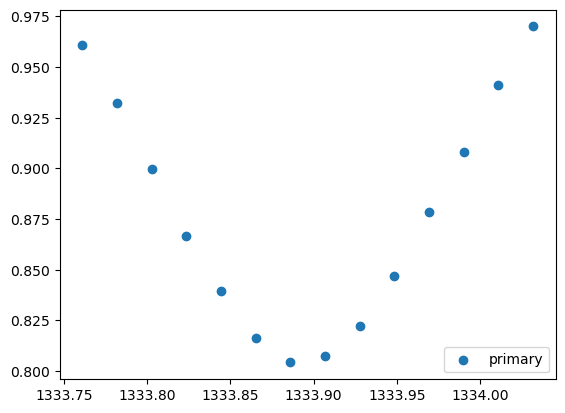

1328.0745553000002 5.8190931 1339.7127415000002


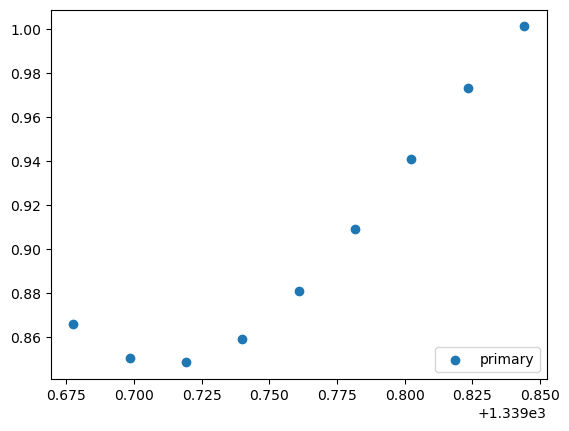

1330.5885553 5.8190931 1330.5885553


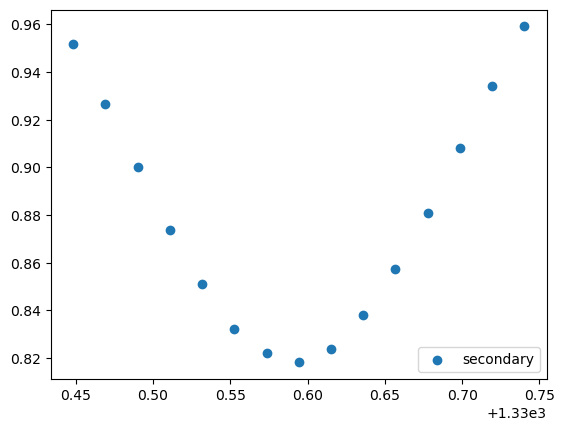

1330.5885553 5.8190931 1336.4076484


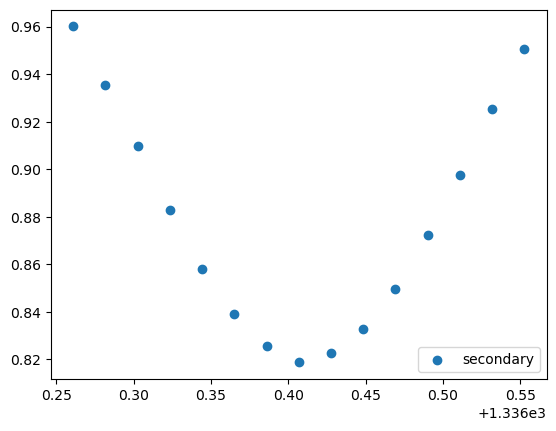

1330.5885553 5.8190931 1342.2267415000001


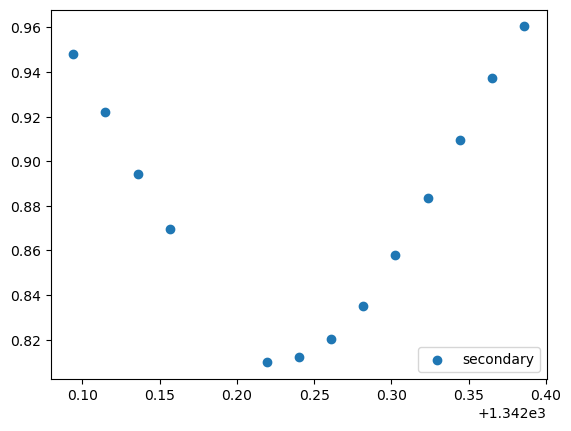

In [16]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in tr_index[0:3]:
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1333.8936484 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.06it/s]


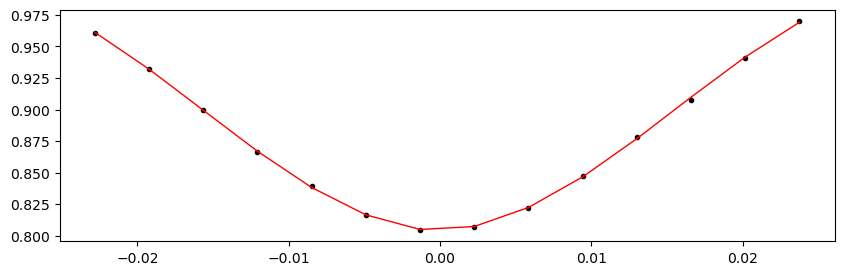

Time 1339.7127415000002 does not have enough data points: 9
1345.5318346000001 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.22it/s]


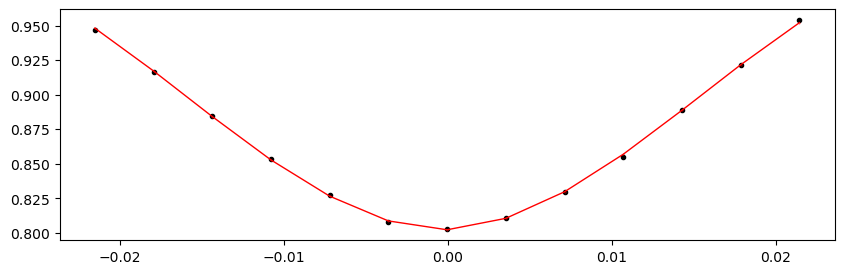

1351.3509277 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.69it/s]


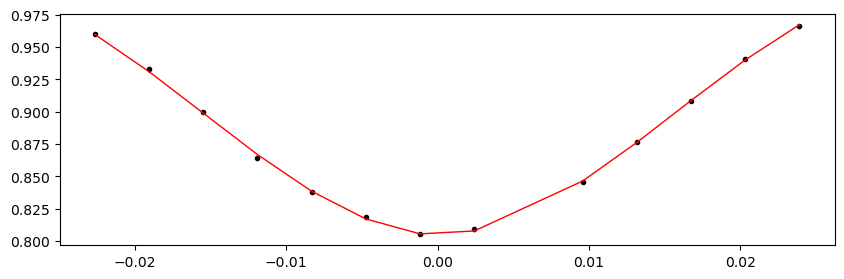

1357.1700208000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.94it/s]


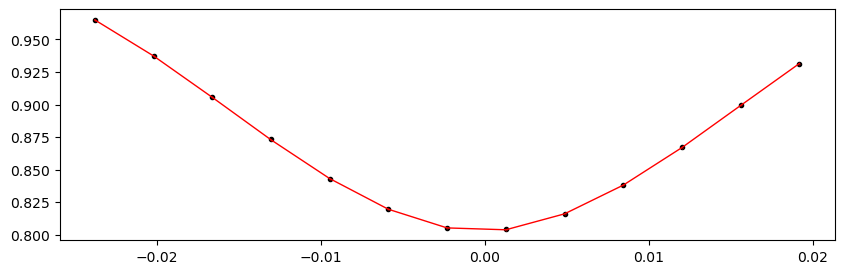

1362.9891139000001 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.39it/s]


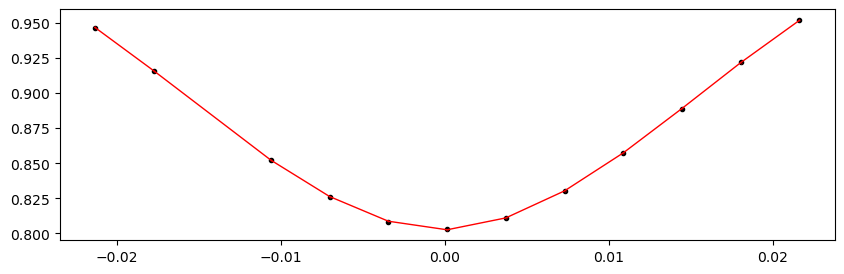

1368.808207 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.47it/s]


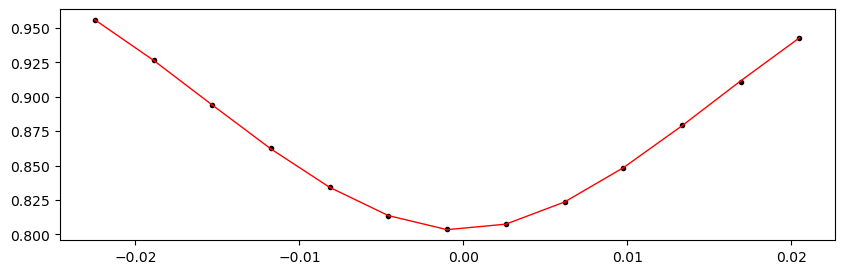

1374.6273001000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.44it/s]


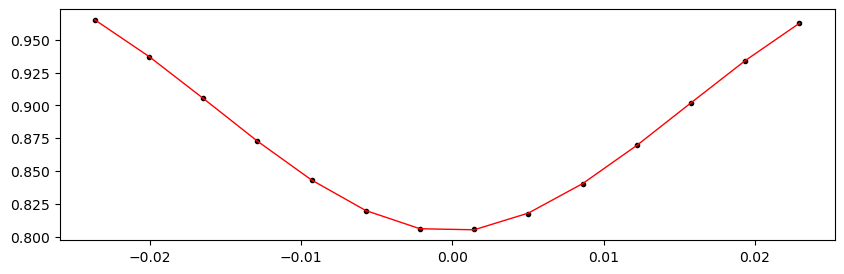

1386.2654863000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.90it/s]


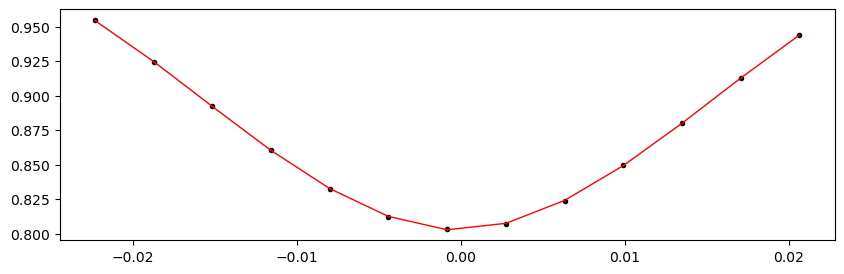

1392.0845794000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.61it/s]


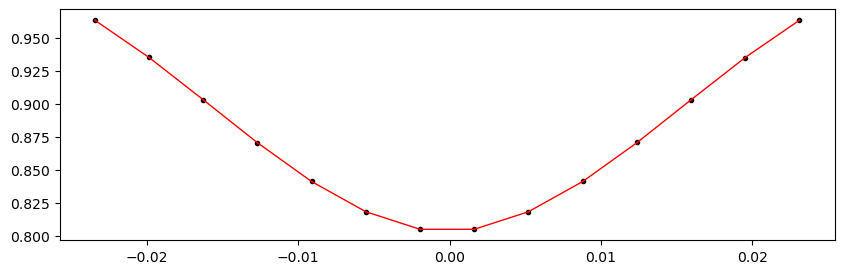

1397.9036725 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.63it/s]


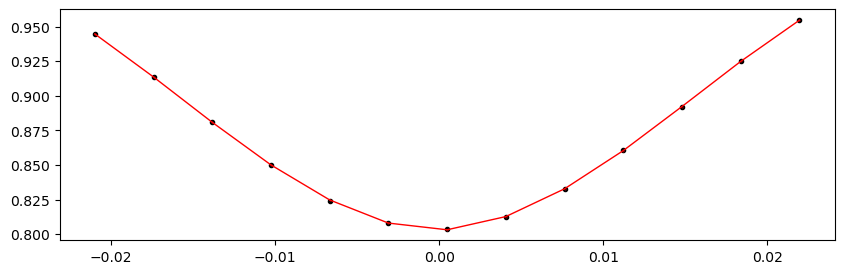

1403.7227656000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.21it/s]


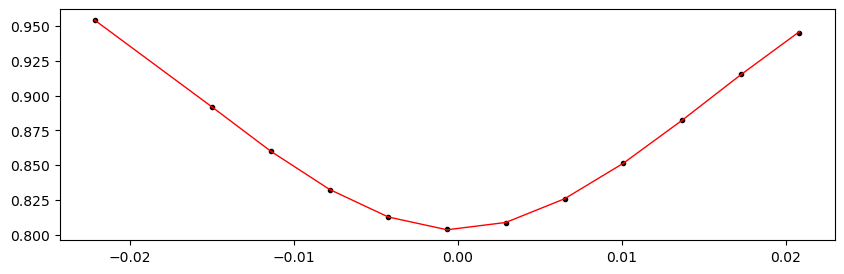

1415.3609518 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.01it/s]


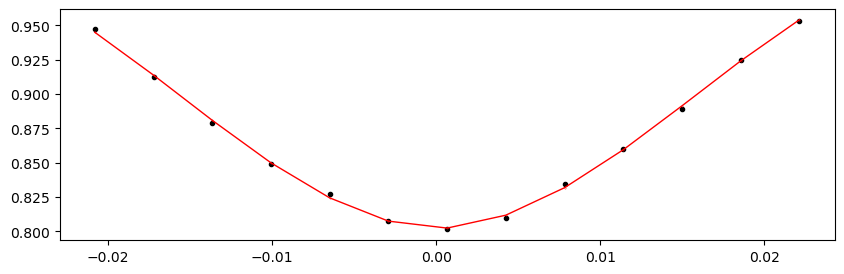

1426.9991380000001 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.91it/s]


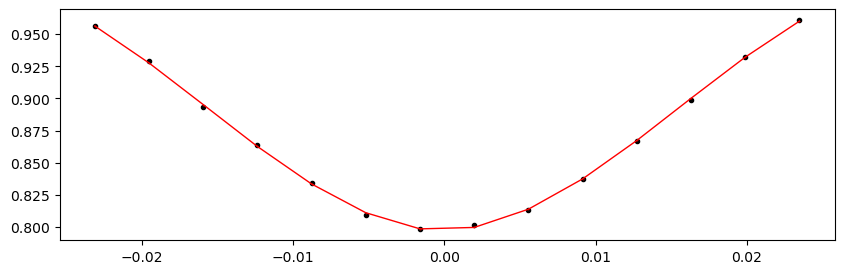

1432.8182311 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.07it/s]


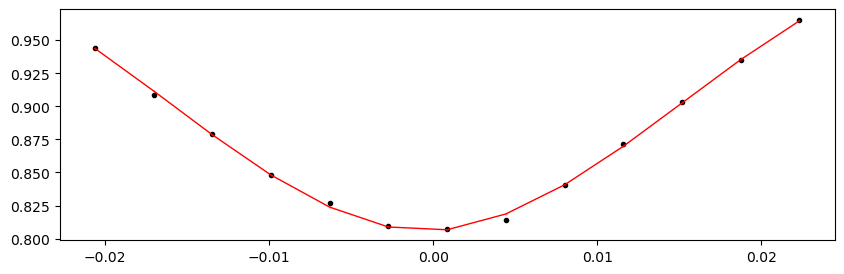

1438.6373242000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.37it/s]


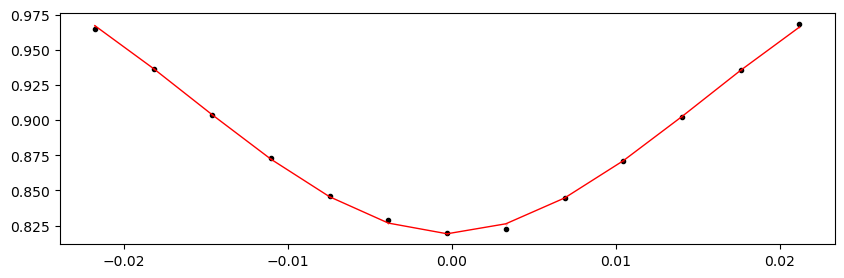

1444.4564173 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.34it/s]


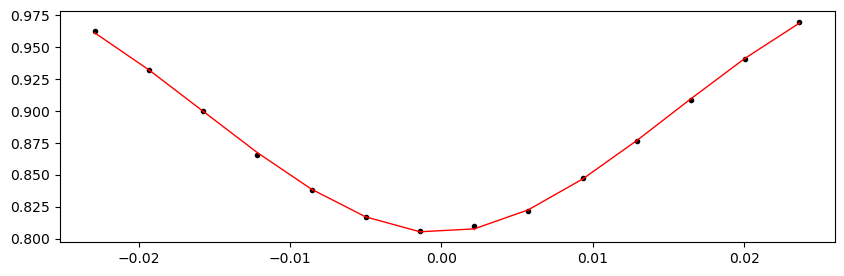

1456.0946035000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.51it/s]


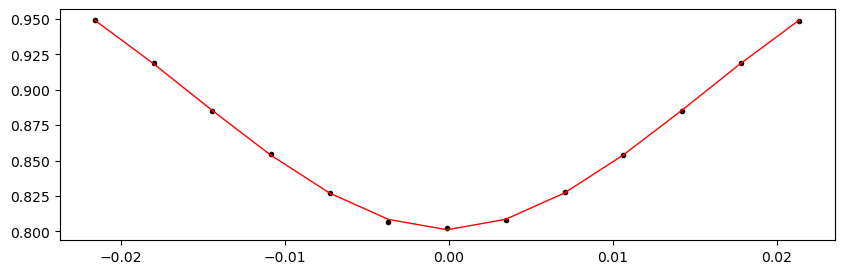

1461.9136966 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.77it/s]


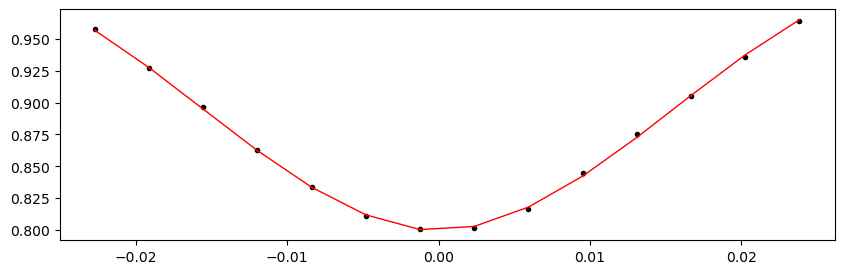

1473.5518828000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.64it/s]


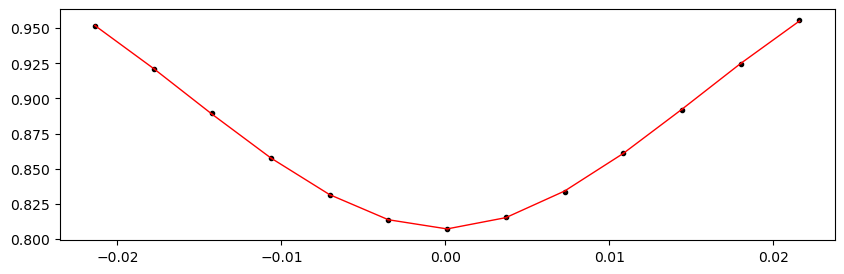

1479.3709759 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.62it/s]


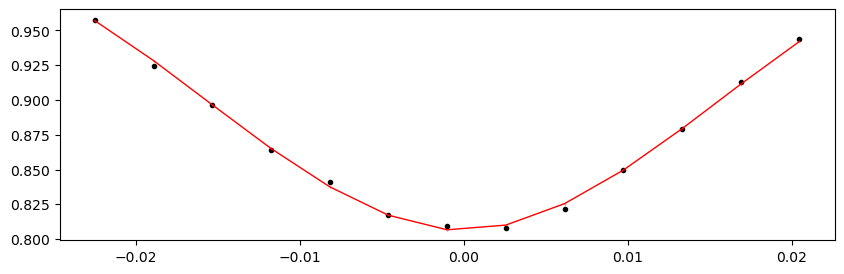

1485.1900690000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.58it/s]


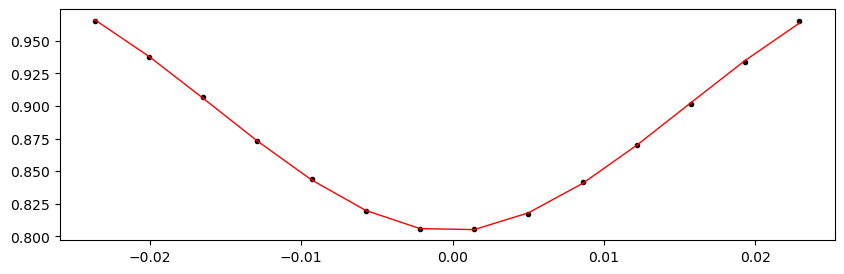

1520.1046276000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.14it/s]


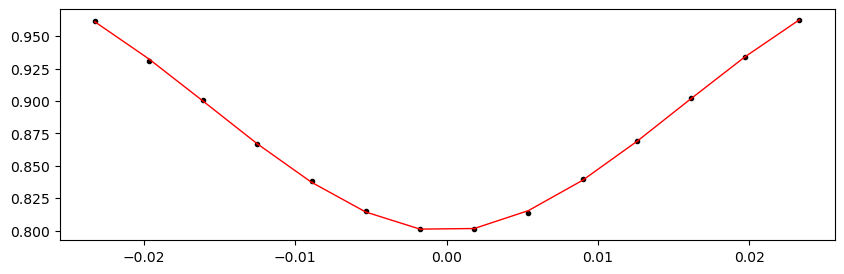

1525.9237207 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.30it/s]


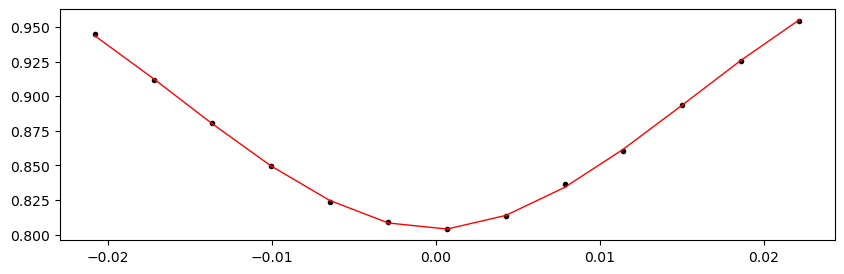

1537.5619069000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.46it/s]


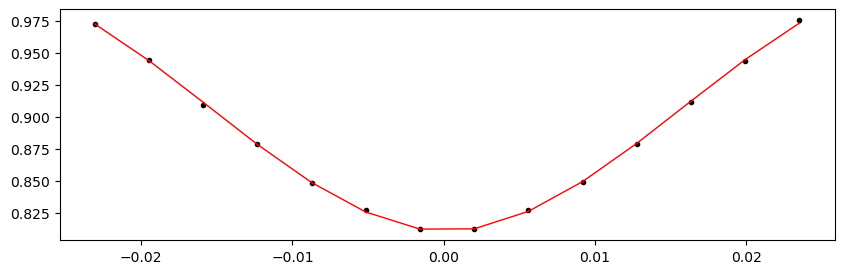

1549.2000931000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.33it/s]


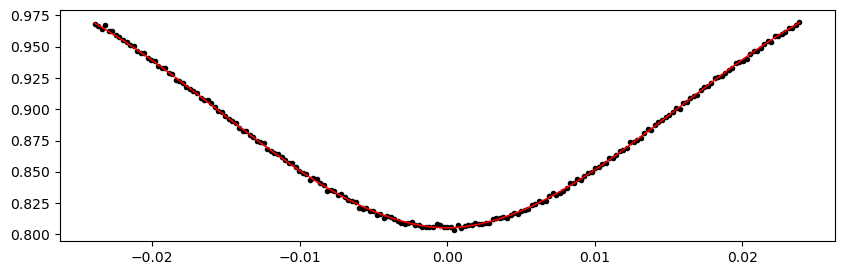

1555.0191862000001 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.54it/s]


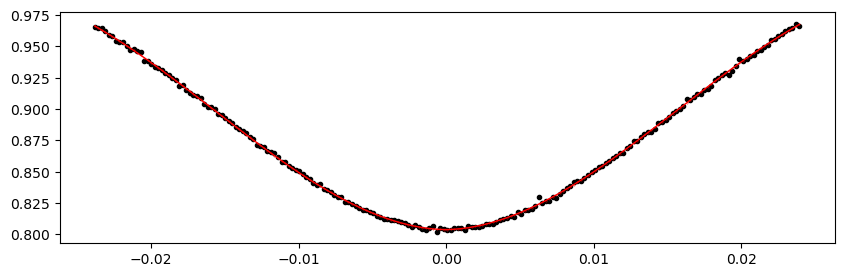

1560.8382793 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.00it/s]


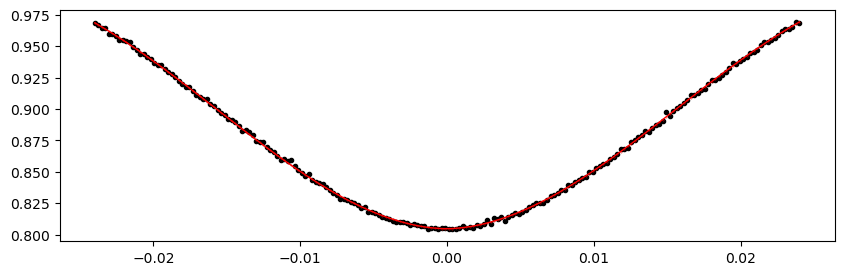

1566.6573724000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.15it/s]


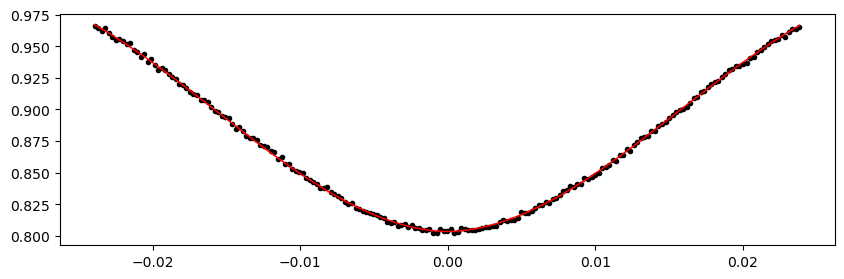

1572.4764655000001 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.64it/s]


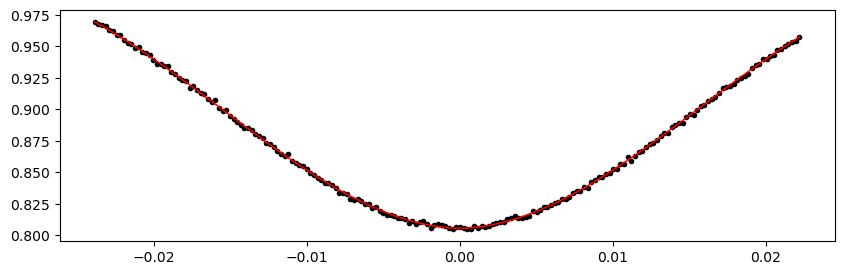

1578.2955586000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.55it/s]


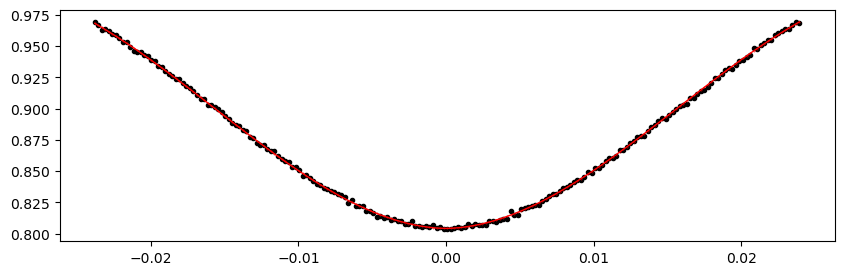

1589.9337448 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.44it/s]


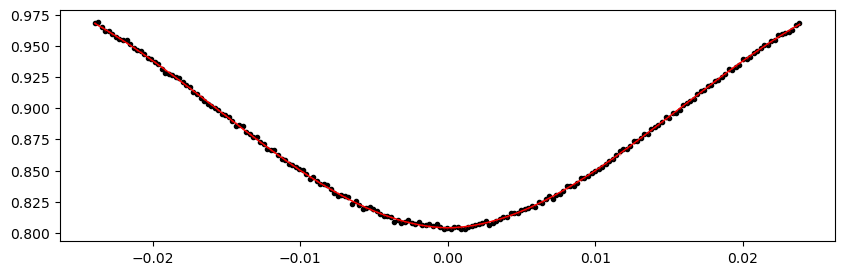

1595.7528379 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.83it/s]


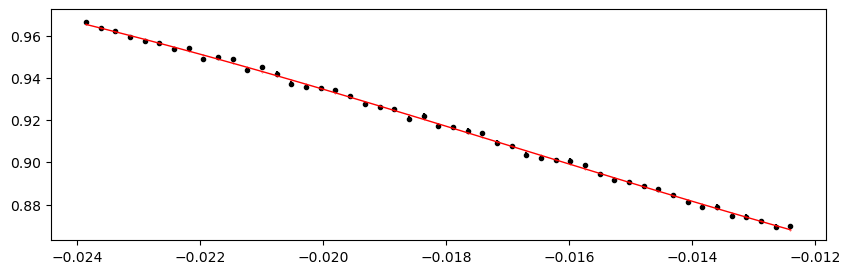

1601.5719310000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.81it/s]


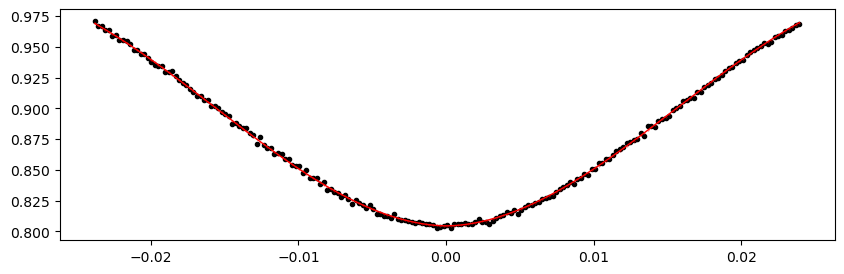

1607.3910241 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.19it/s]


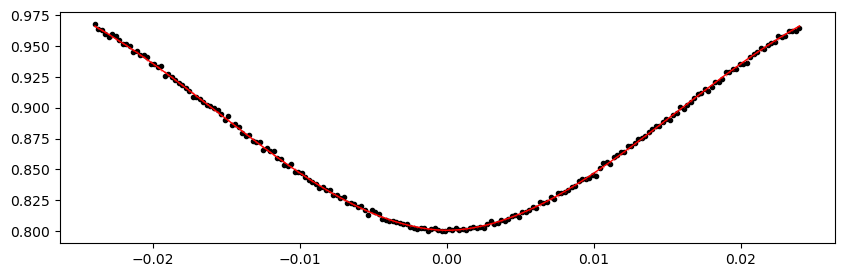

1619.0292103000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.43it/s]


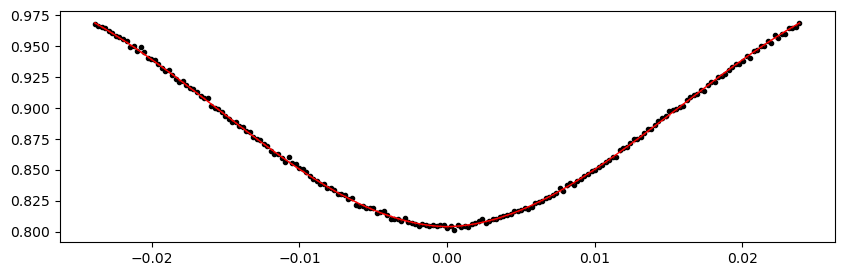

1630.6673965000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.40it/s]


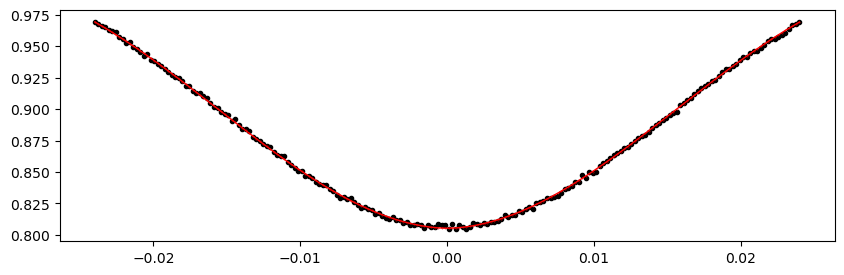

1636.4864896000001 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.39it/s]


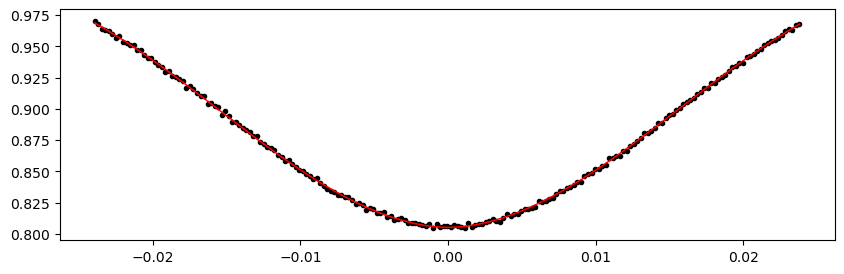

1642.3055827000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.57it/s]


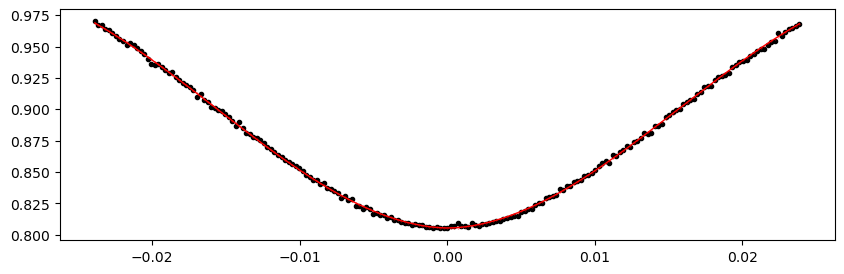

1648.1246758000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.52it/s]


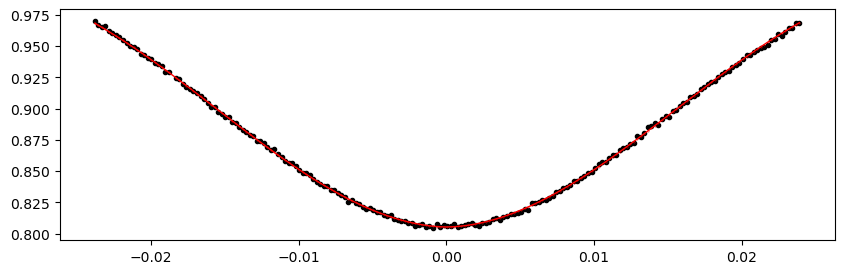

1653.9437689000001 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.87it/s]


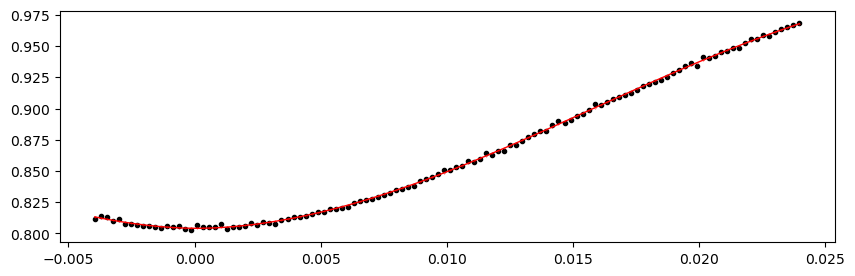

1659.762862 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.03it/s]


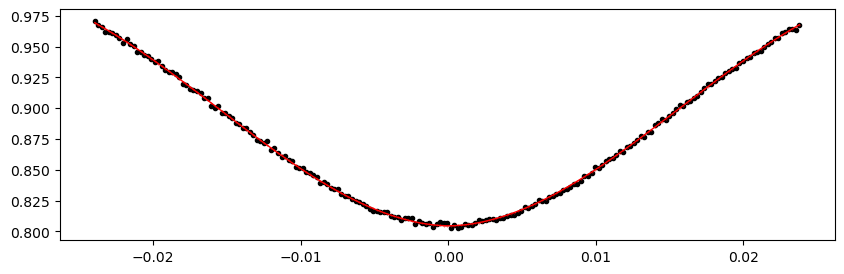

1665.5819551000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.87it/s]


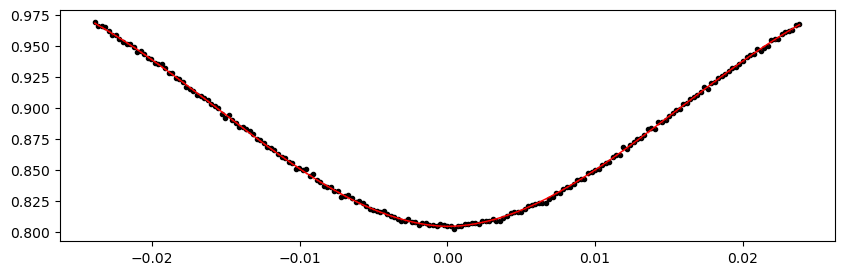

1671.4010482 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.70it/s]


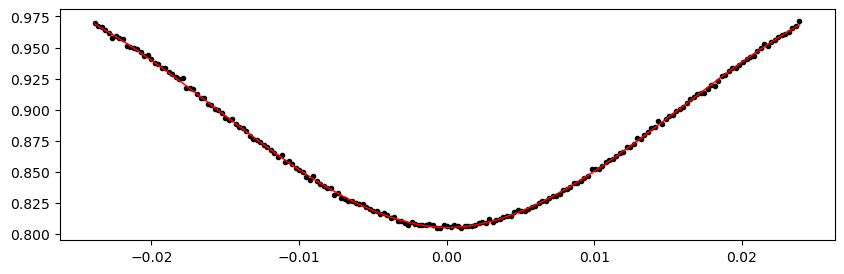

1677.2201413000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.98it/s]


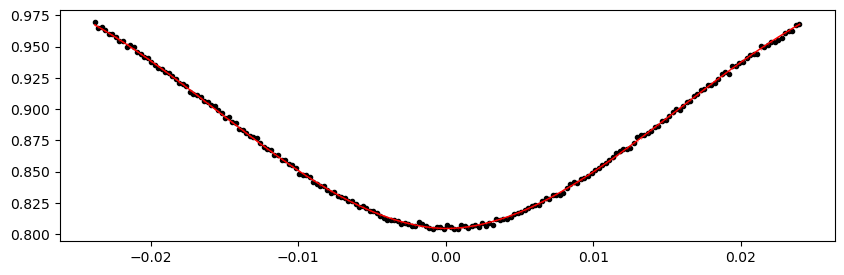

2067.099379 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.77it/s]


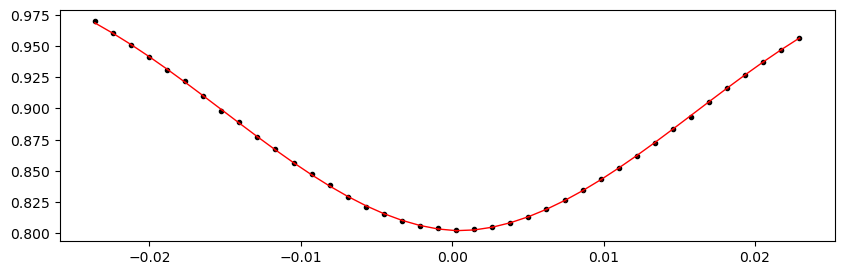

2078.7375652 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.50it/s]


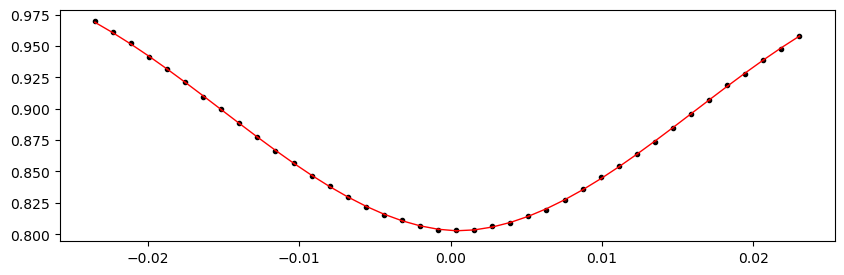

2084.5566583 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.48it/s]


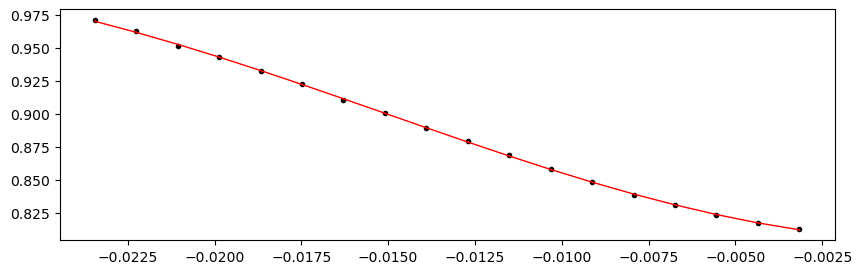

2090.3757514 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.96it/s]


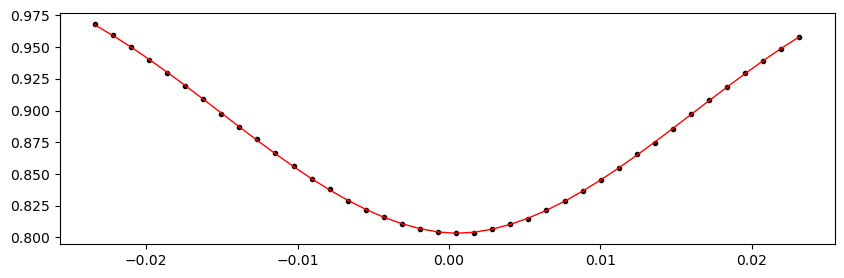

2096.1948445000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.20it/s]


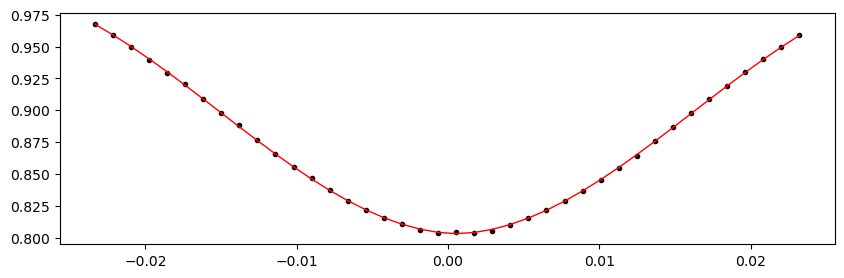

2107.8330307 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.72it/s]


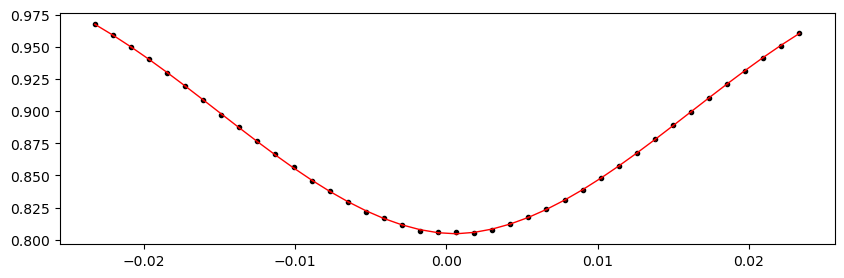

2119.4712169000004 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.74it/s]


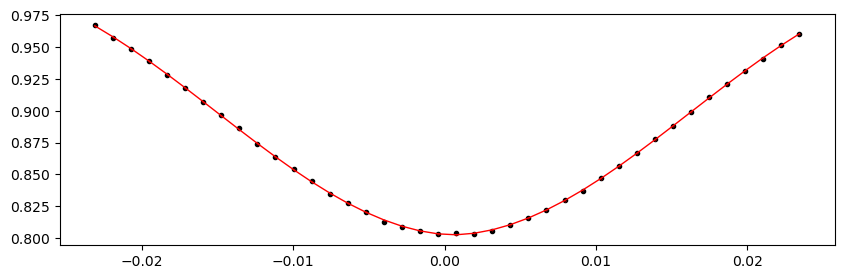

2125.2903100000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.67it/s]


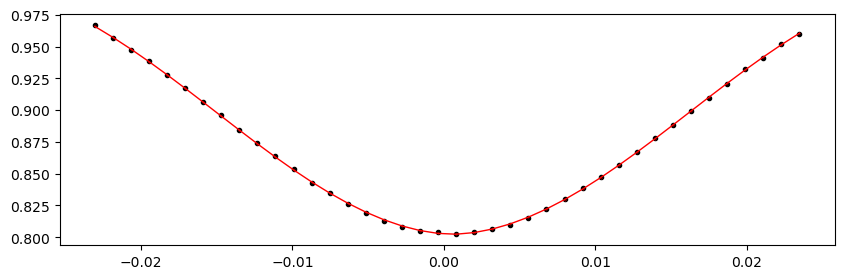

2131.1094031000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.30it/s]


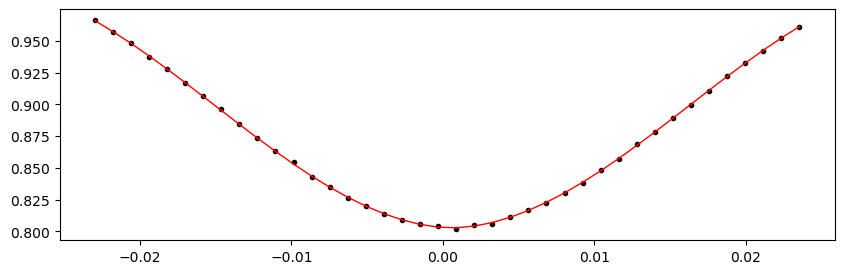

2136.9284962 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.63it/s]


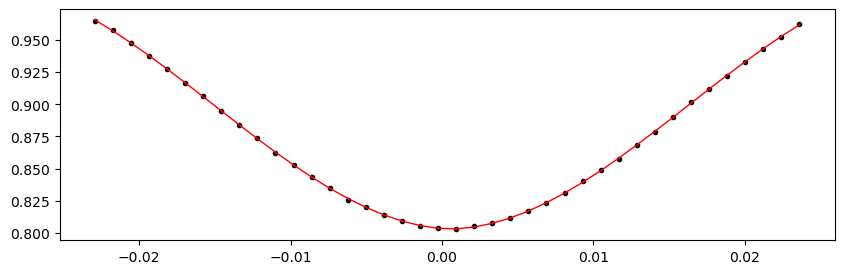

2148.5666824 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.90it/s]


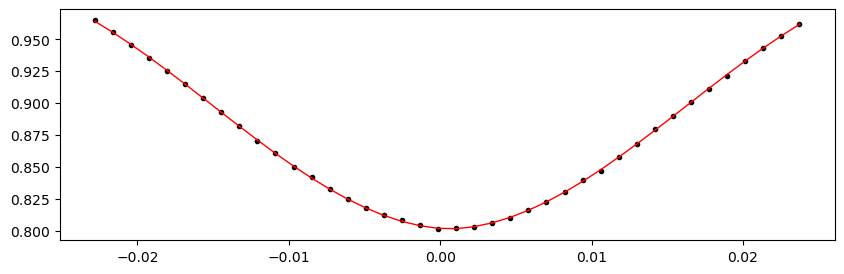

2154.3857755 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.07it/s]


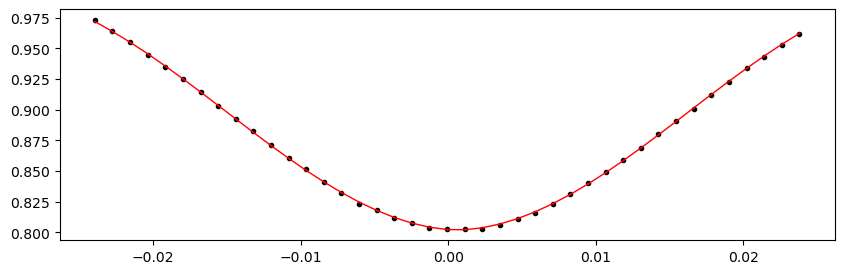

2160.2048686000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.62it/s]


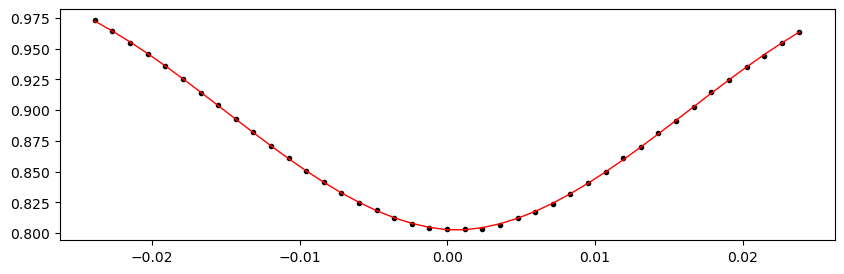

2166.0239617 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.37it/s]


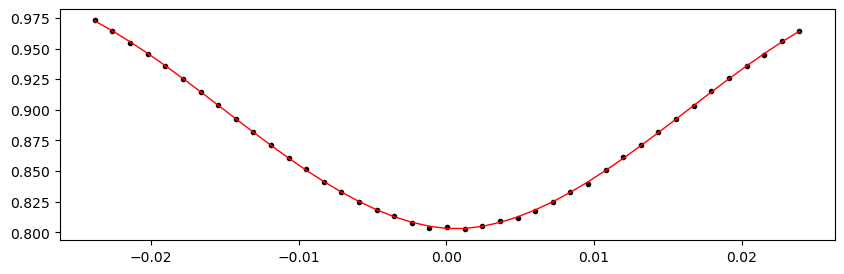

2177.6621479 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.19it/s]


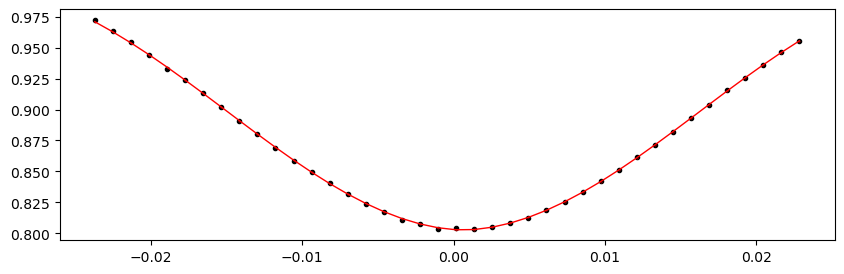

2183.4812410000004 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.52it/s]


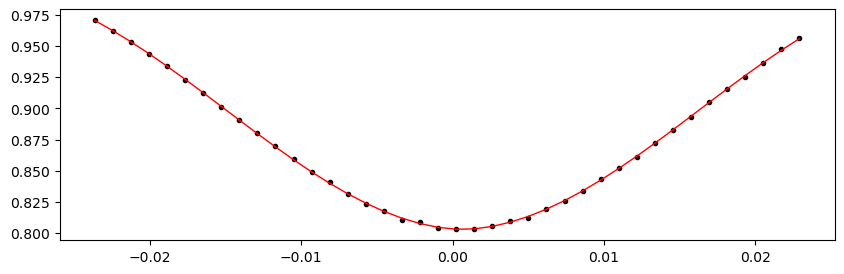

2189.3003341000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.75it/s]


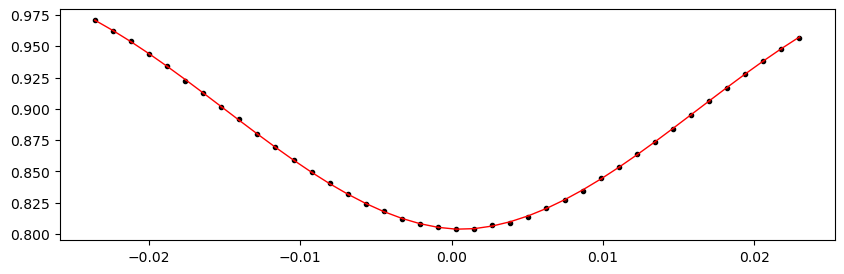

2195.1194272000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.68it/s]


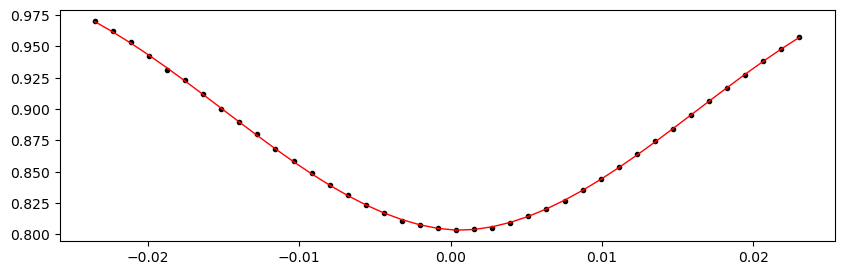

2206.7576134 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.21it/s]


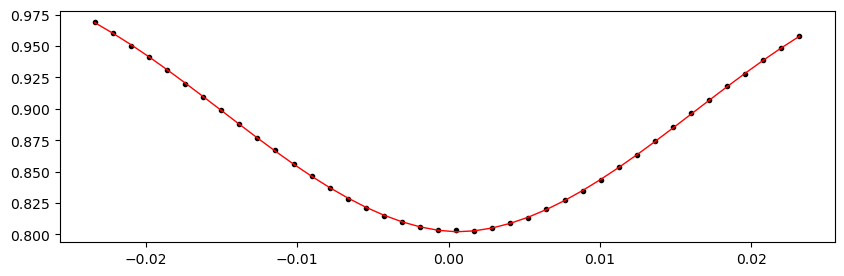

2212.5767065 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.87it/s]


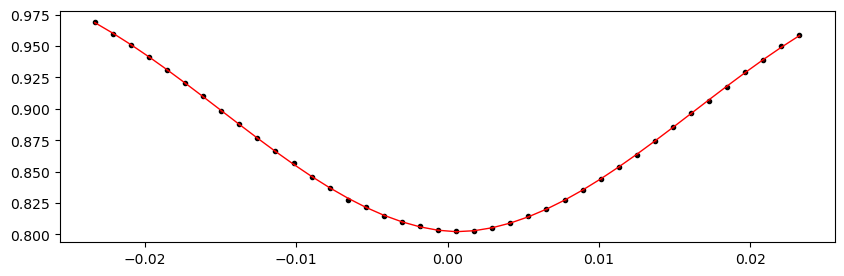

2218.3957996 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.83it/s]


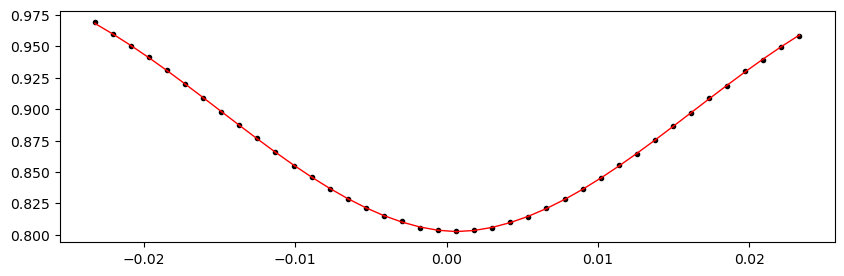

2224.2148927000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.15it/s]


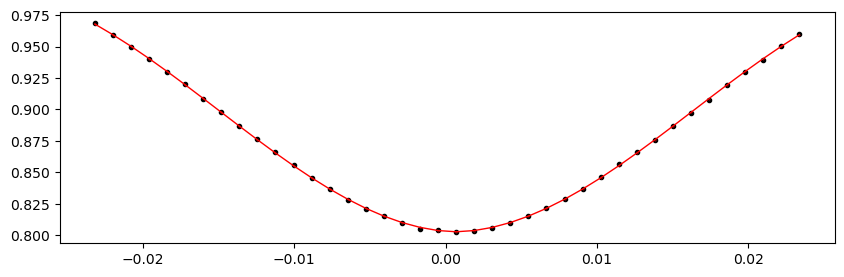

2230.0339858 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.78it/s]


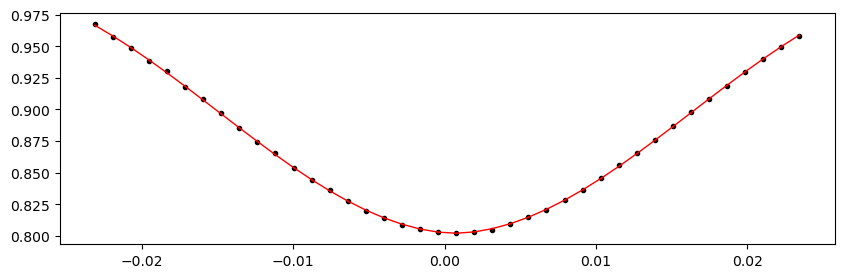

2235.8530789 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.10it/s]


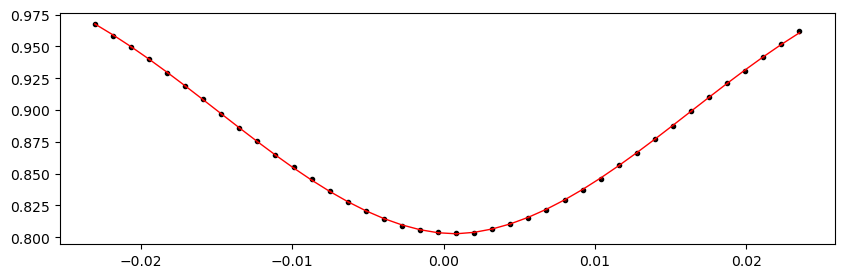

2247.4912651000004 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.29it/s]


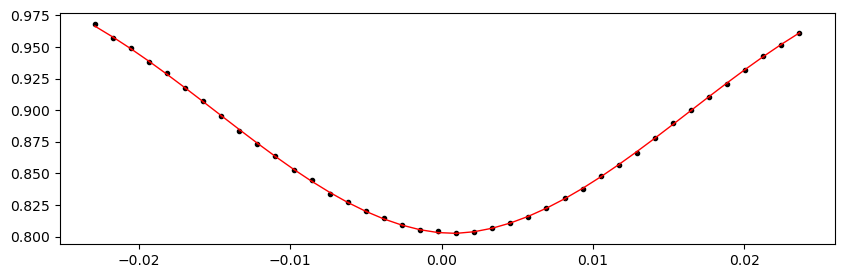

2253.3103582000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.33it/s]


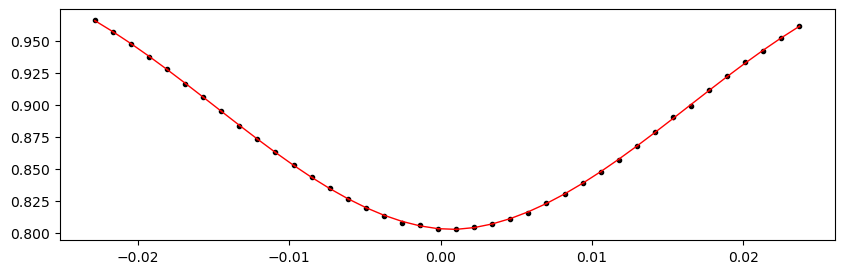

2259.1294513000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.11it/s]


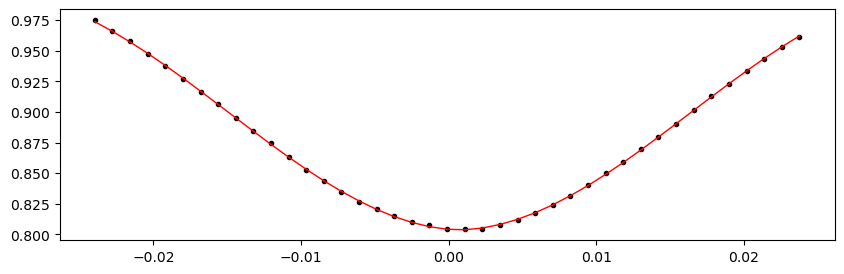

2264.9485444 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.09it/s]


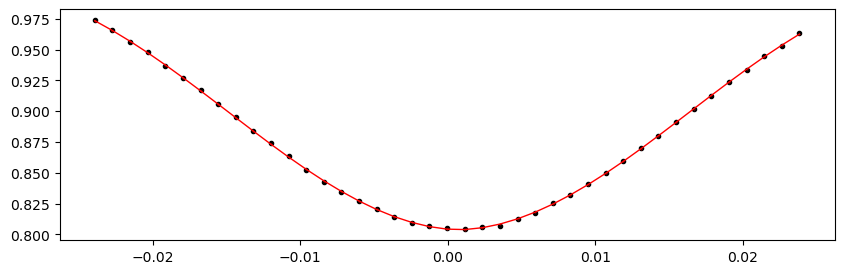

2276.5867306 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.80it/s]


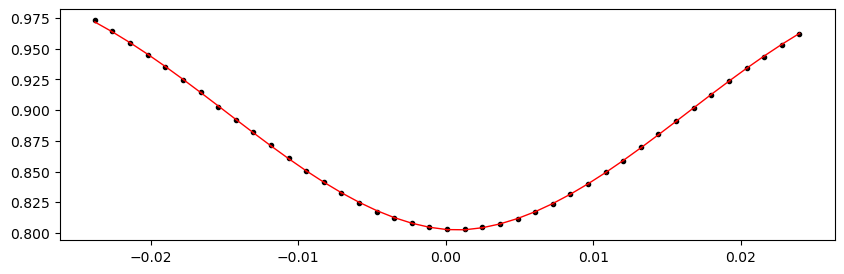

2282.4058237 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.29it/s]


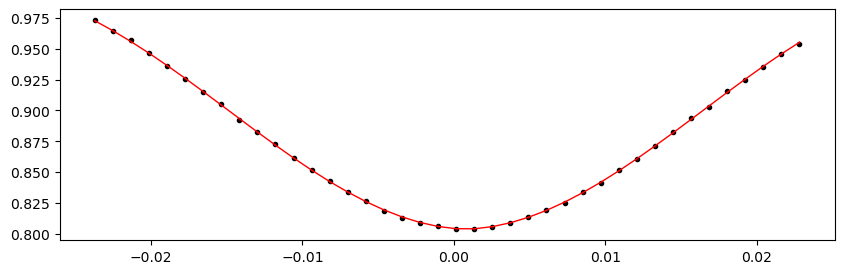

2288.2249168000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.55it/s]


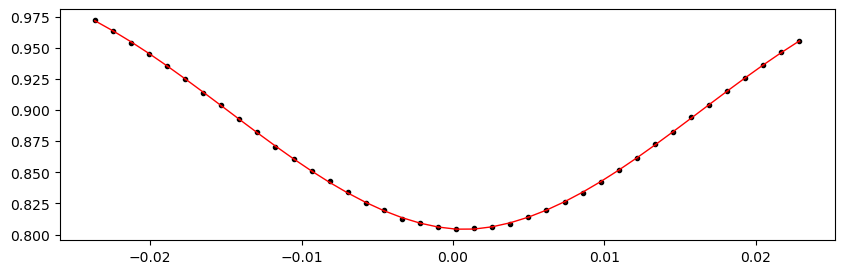

2299.863103 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.45it/s]


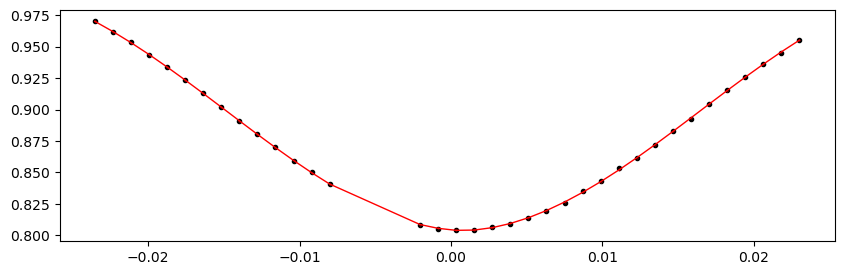

2305.6821961 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.41it/s]


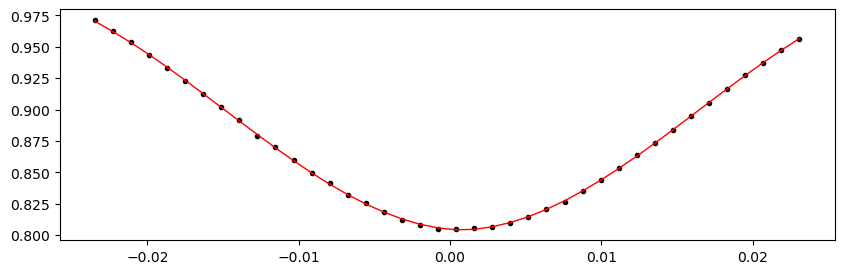

2334.7776616 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.18it/s]


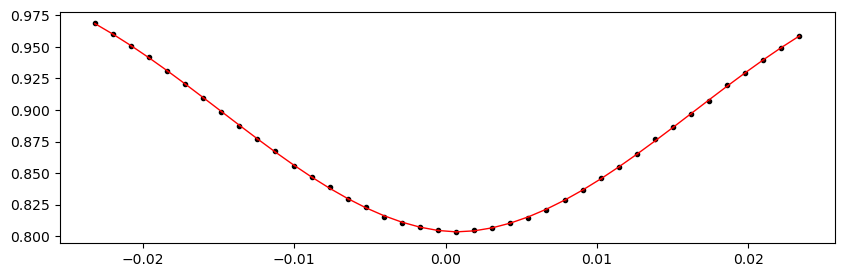

2340.5967547 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.28it/s]


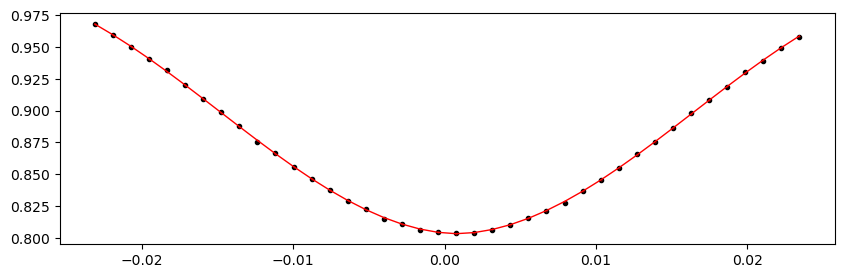

Time 2346.4158478 does not have enough data points: 8
2352.2349409 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.45it/s]


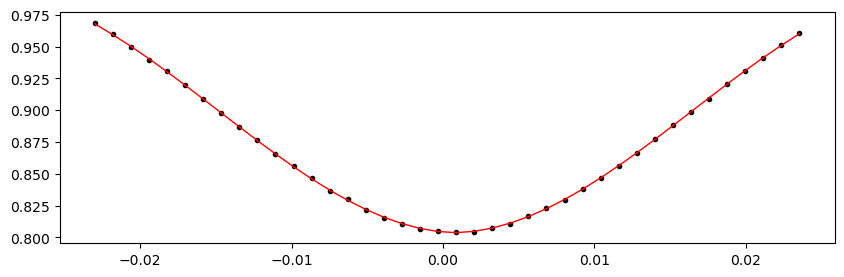

2358.0540340000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.28it/s]


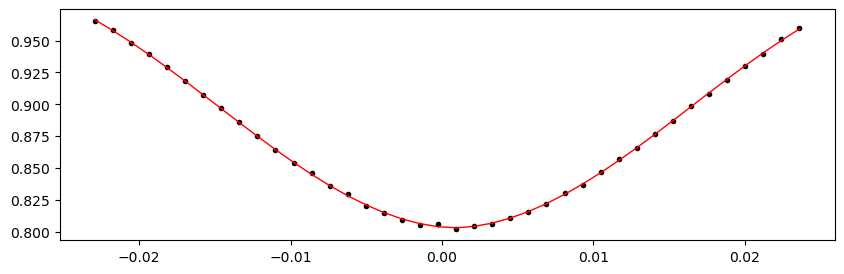

2363.8731271 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.93it/s]


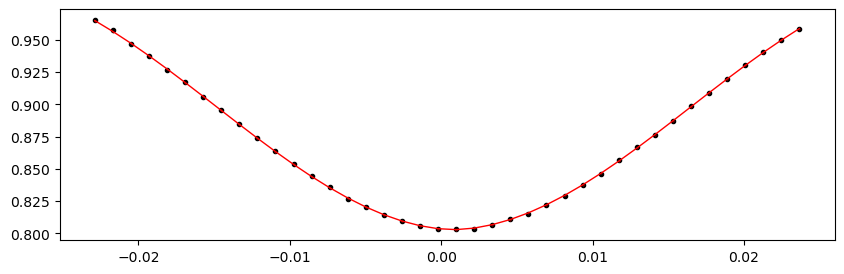

2369.6922202 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.98it/s]


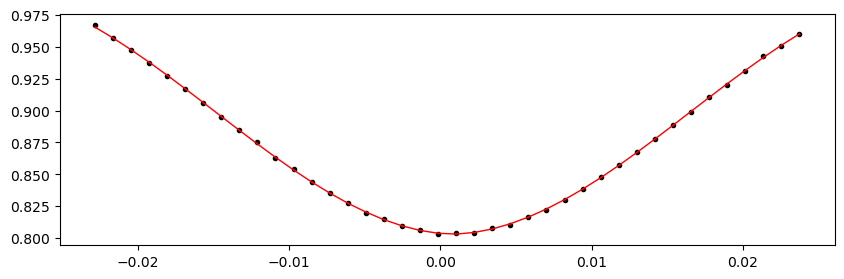

2381.3304064000004 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.98it/s]


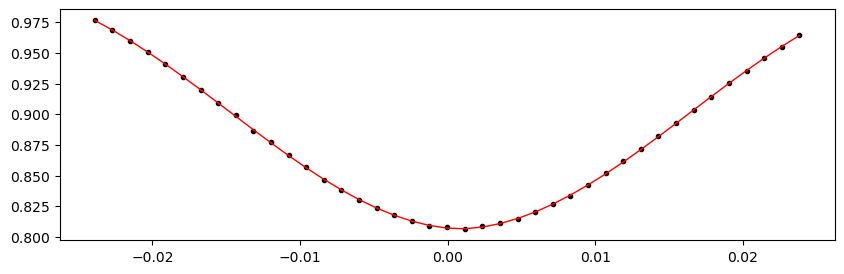

2387.1494995000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.86it/s]


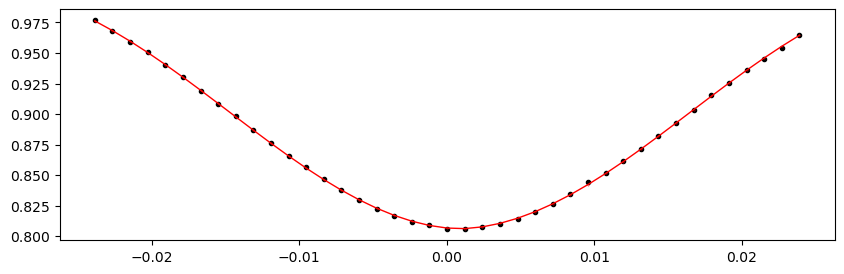

2969.0588095000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.02it/s]


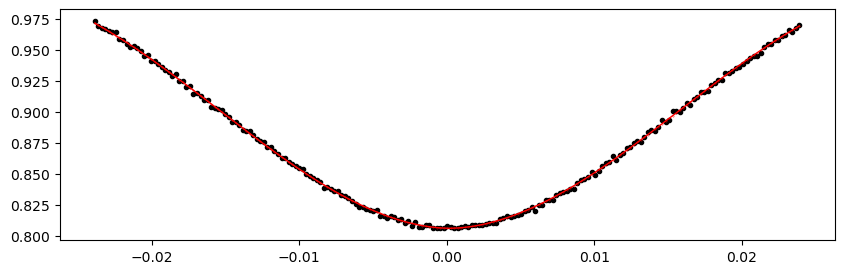

2974.8779026 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.65it/s]


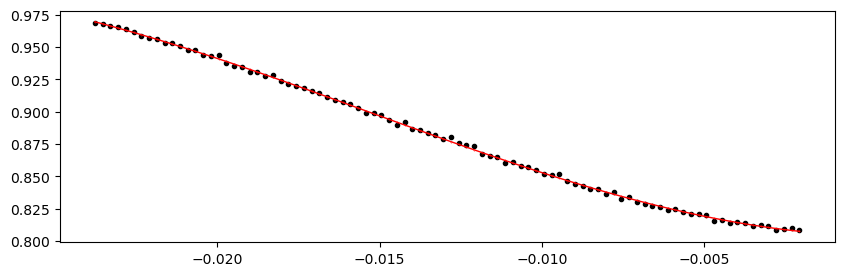

2980.6969957 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.95it/s]


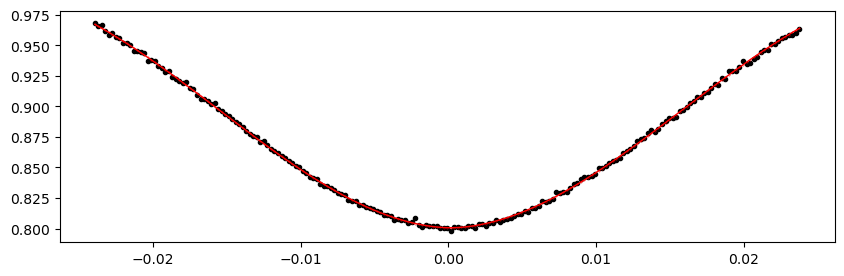

2986.5160888 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.05it/s]


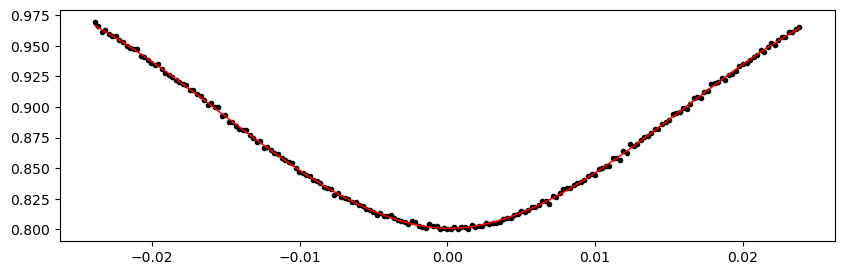

2992.3351819 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.06it/s]


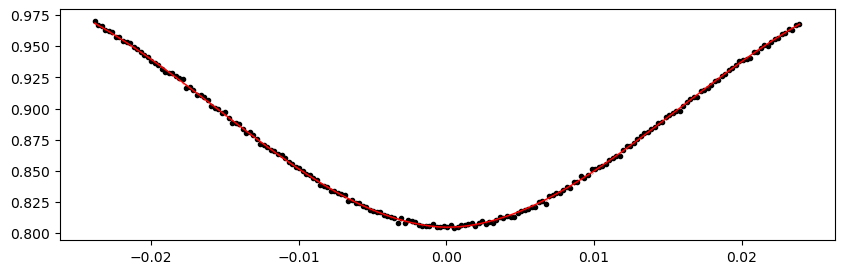

2998.154275 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.48it/s]


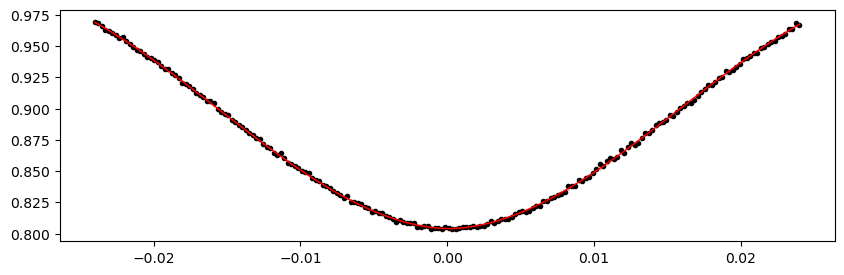

3003.9733681000002 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.20it/s]


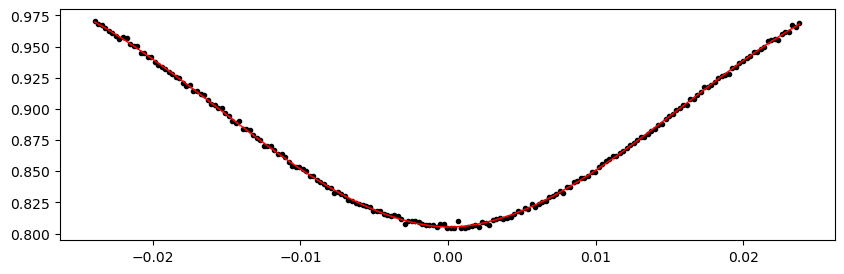

3009.7924612 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.57it/s]


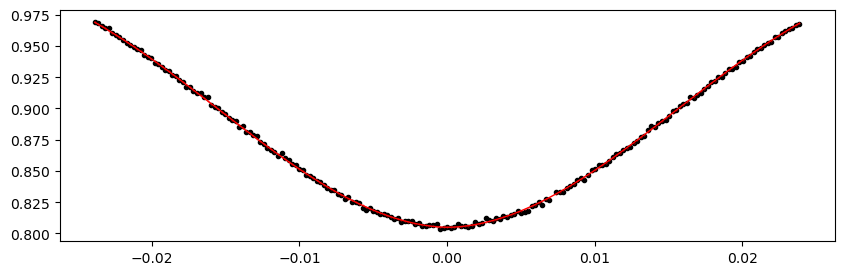

3015.6115543 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.04it/s]


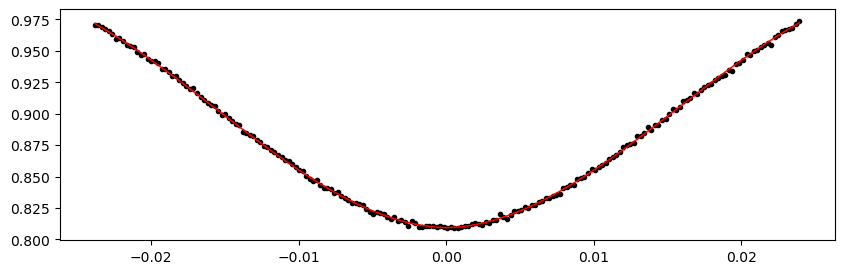

3021.4306474000005 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.76it/s]


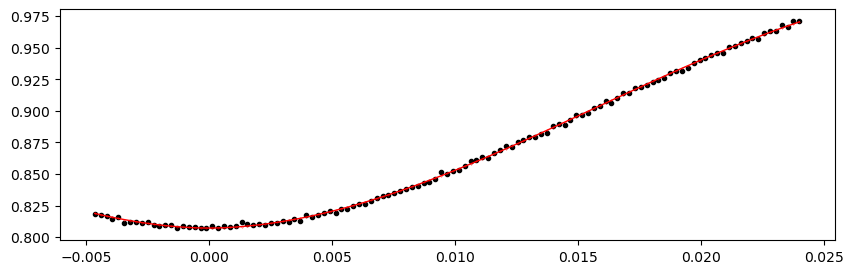

3027.2497405000004 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.76it/s]


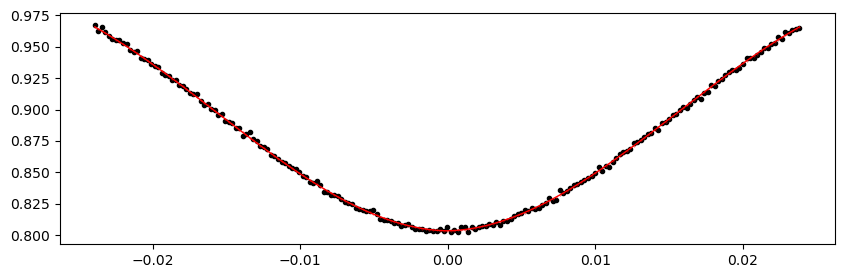

3033.0688336000003 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.61it/s]


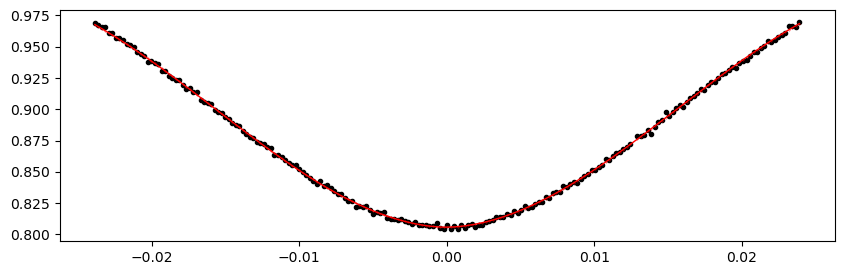

3038.8879267 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.67it/s]


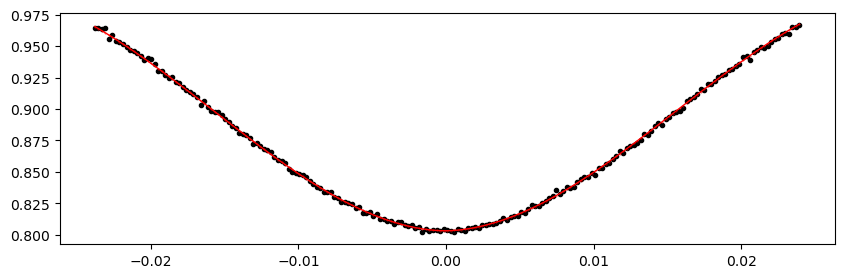

3044.7070198 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.92it/s]


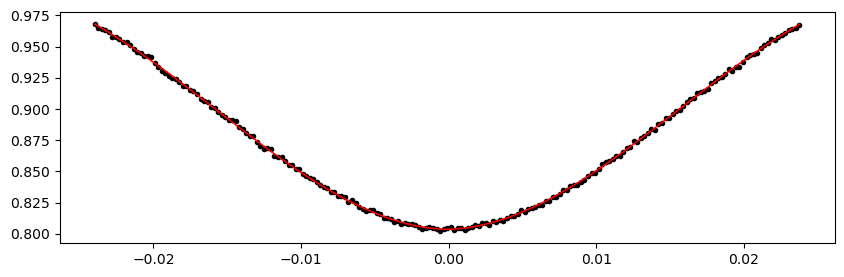

3050.5261129 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.81it/s]


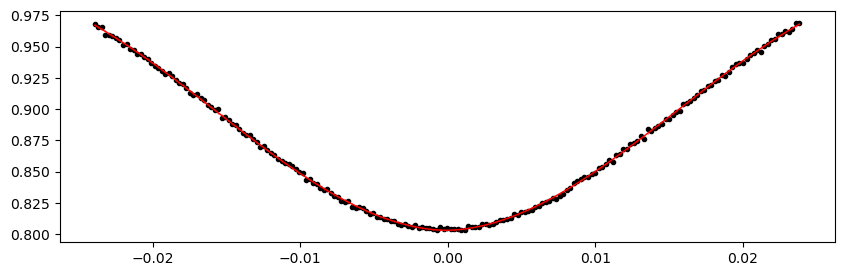

3056.345206 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.83it/s]


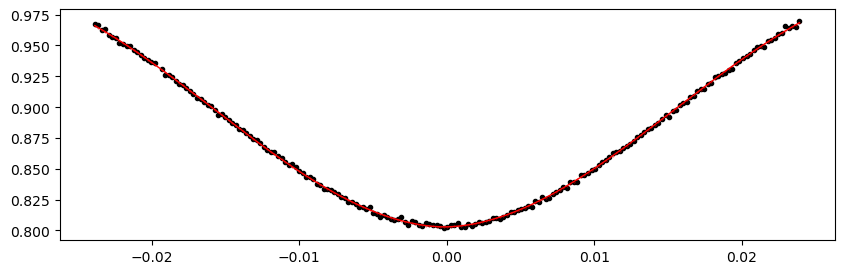

3062.1642991 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.75it/s]


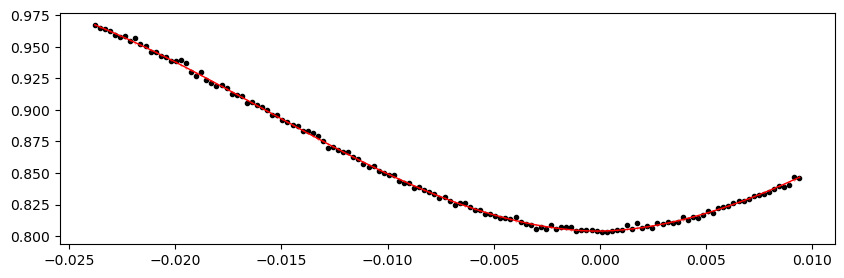

3067.9833922 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.10it/s]


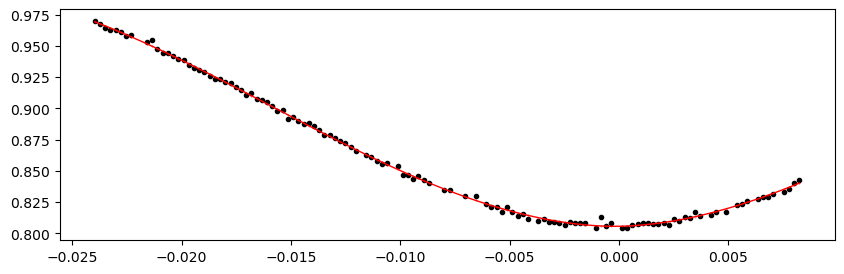

3073.8024853 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.51it/s]


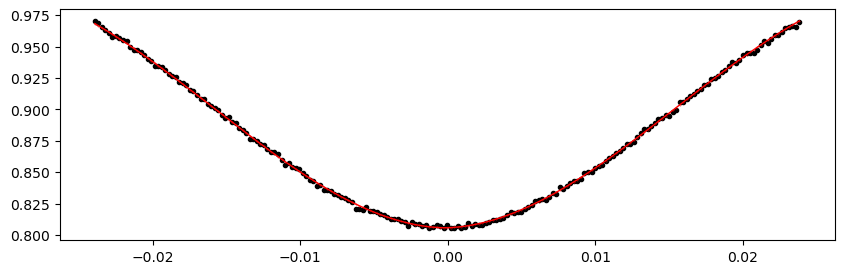

3079.6215784 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|████████████████████████████████████████████████████████| 10000/10000 [02:59<00:00, 55.72it/s]


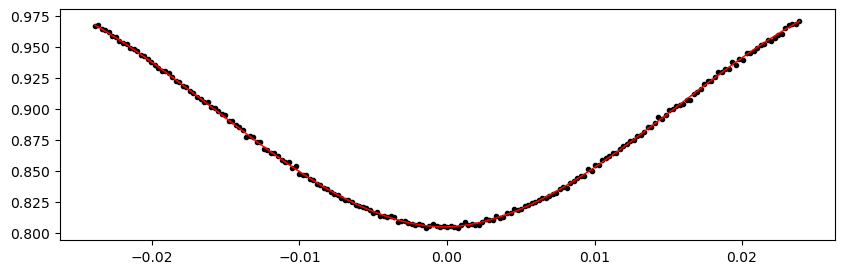

3085.4406715000005 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 273.37it/s]


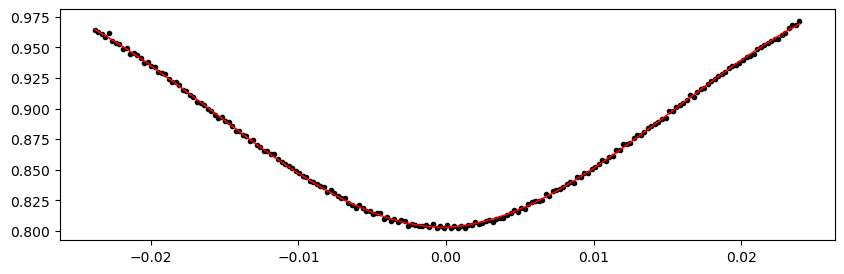

3091.2597646000004 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|██████████████████████████████████████████████████████| 10000/10000 [3:12:26<00:00,  1.15s/it]


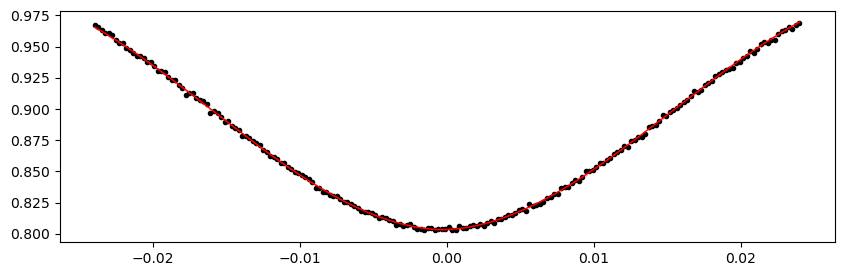

3102.8979508 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.16it/s]


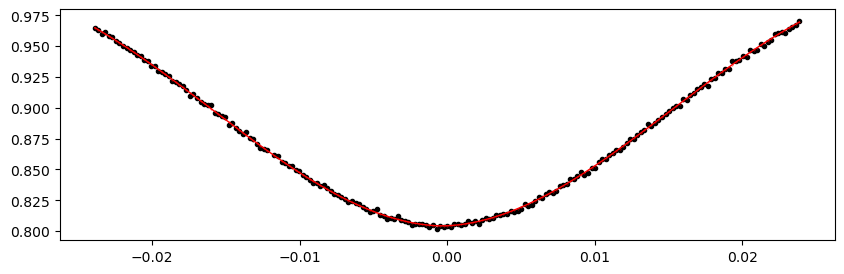

3114.536137 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.33it/s]


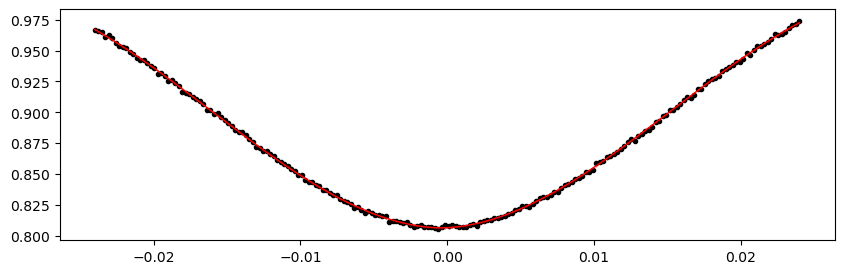

3120.3552301 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.67it/s]


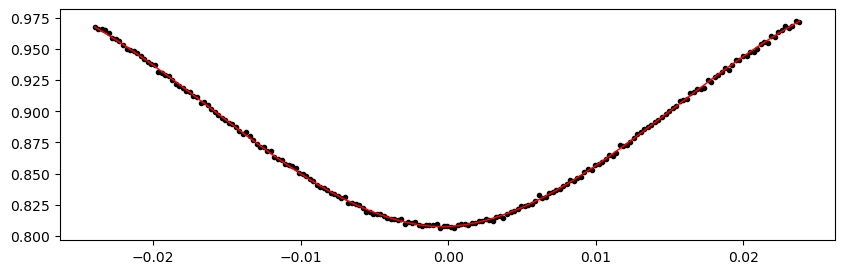

3131.9934163 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.58it/s]


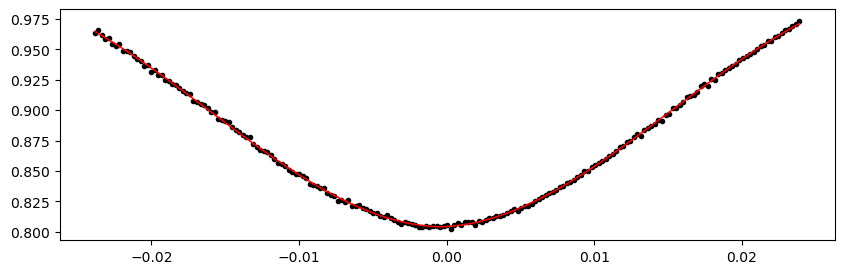

3143.6316025 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.89it/s]


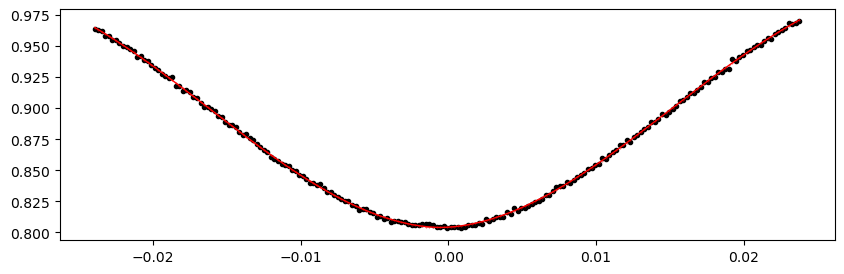

3149.4506956 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.96it/s]


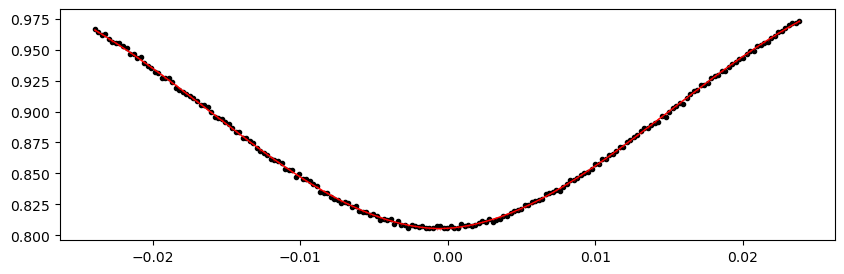

3184.3652542 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.17it/s]


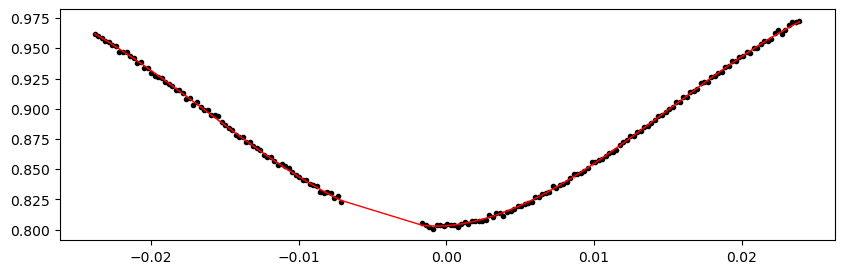

3190.1843473 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.33it/s]


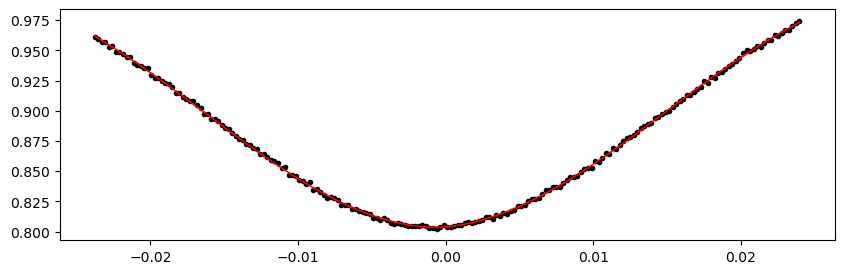

3196.0034404 1.014826475078101 -0.21053037767239002 0.19455958198552775


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.40it/s]


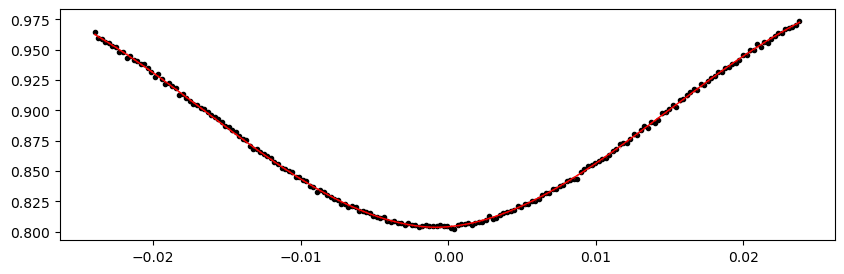

In [19]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=10,  # accomodate 30-min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Time 1348.0458346 does not have enough data points: 8
Number 5 has already been completed -- skip
1365.5031139 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.43it/s]


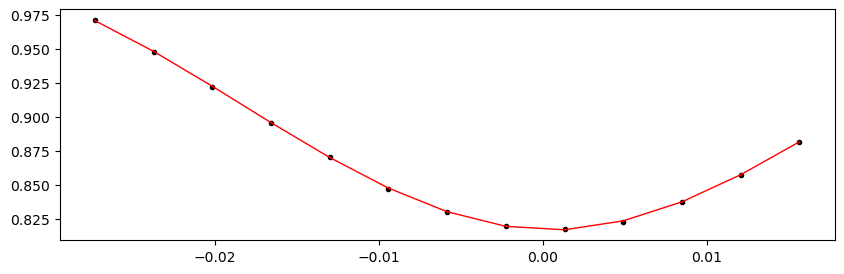

1371.3222070000002 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.60it/s]


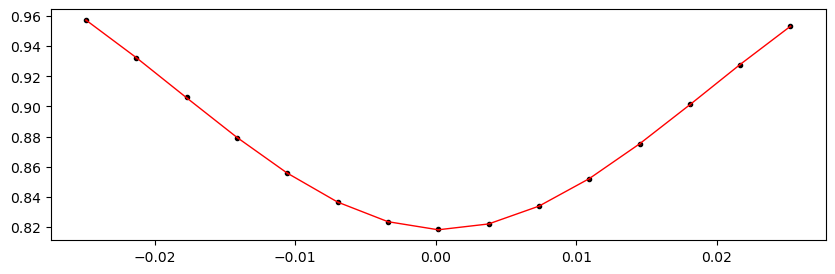

1377.1413001 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.09it/s]


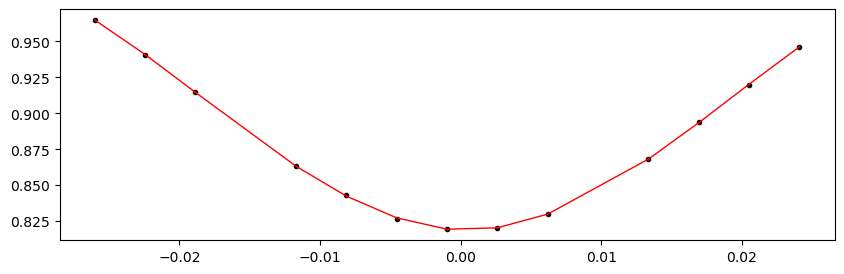

1388.7794863000001 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.23it/s]


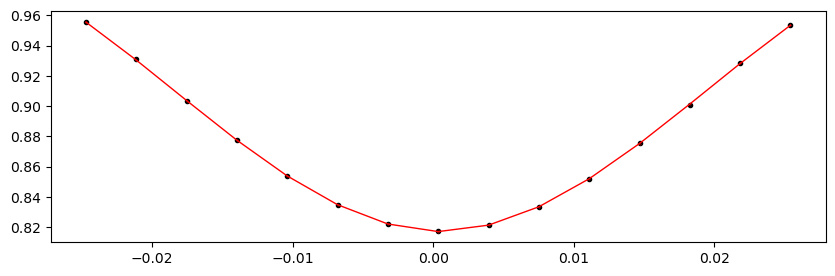

1400.4176725 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.30it/s]


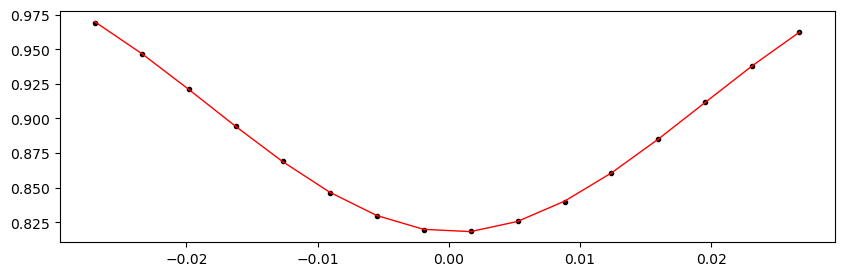

Time 1406.2367656000001 does not have enough data points: 6
1412.0558587 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.55it/s]


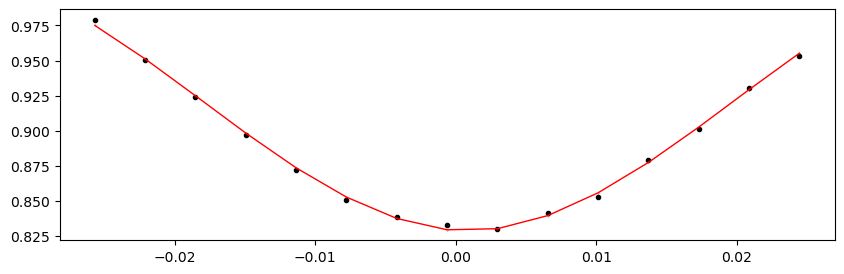

1417.8749518 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.49it/s]


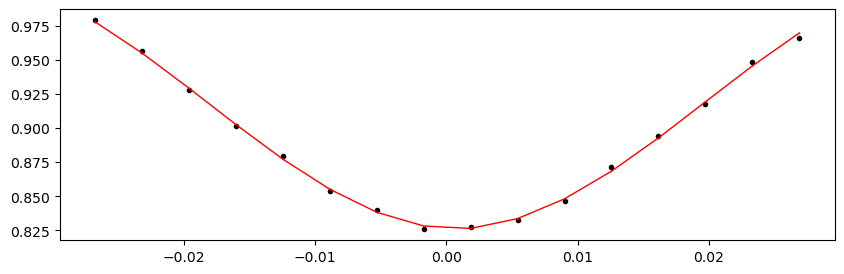

1429.513138 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.70it/s]


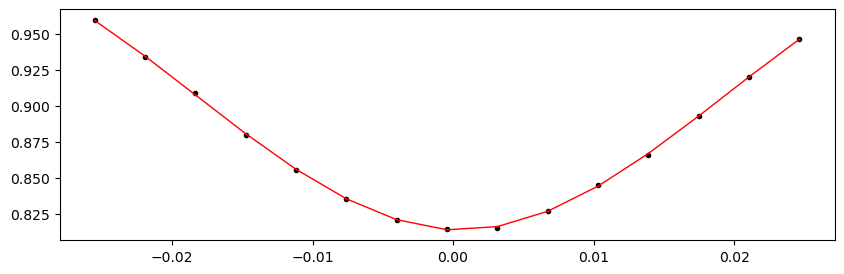

1435.3322311000002 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.47it/s]


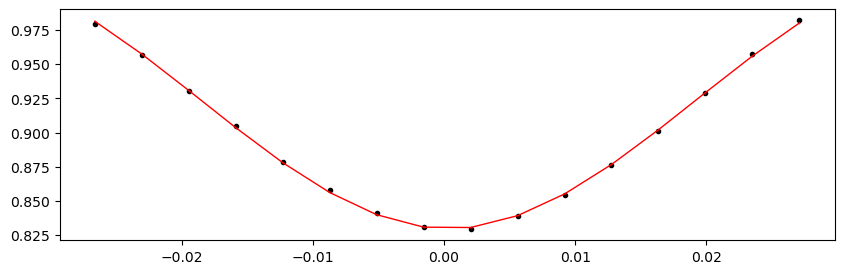

Time 1441.1513242 does not have enough data points: 10
1446.9704173 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.48it/s]


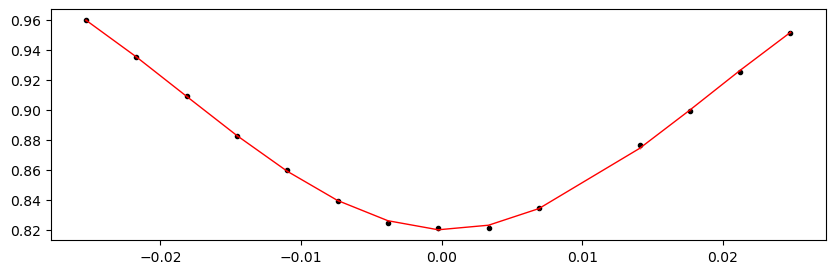

1452.7895104000002 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.18it/s]


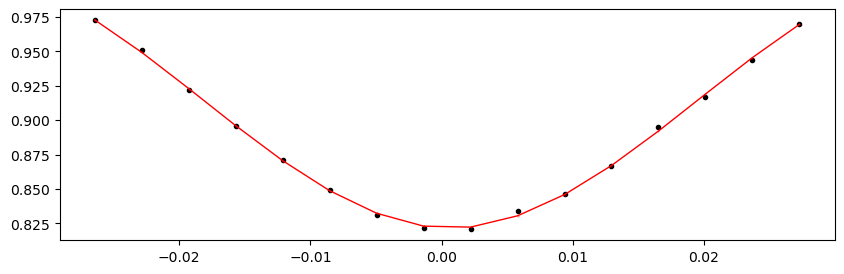

1458.6086035 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.72it/s]


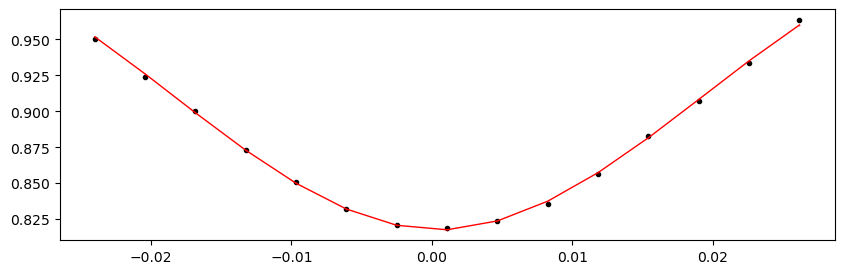

1470.2467897000001 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.85it/s]


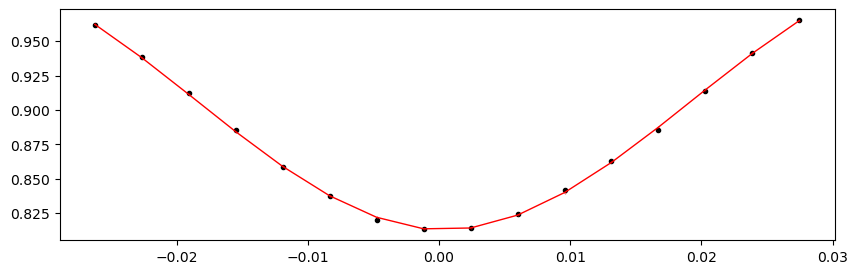

1476.0658828 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.98it/s]


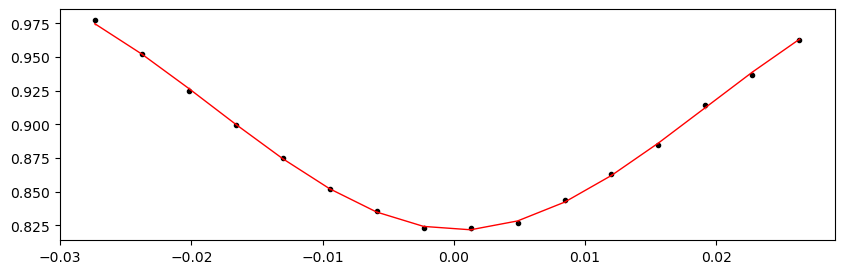

1481.8849759 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.77it/s]


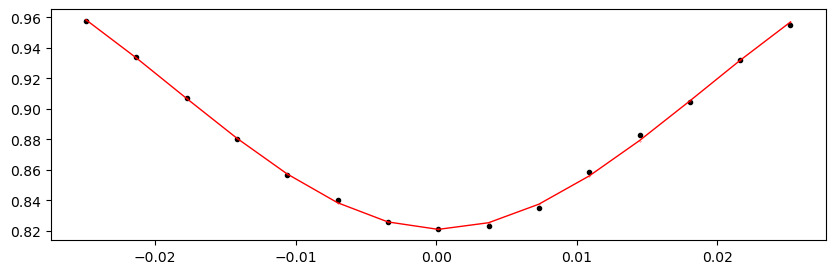

1487.7040690000001 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.21it/s]


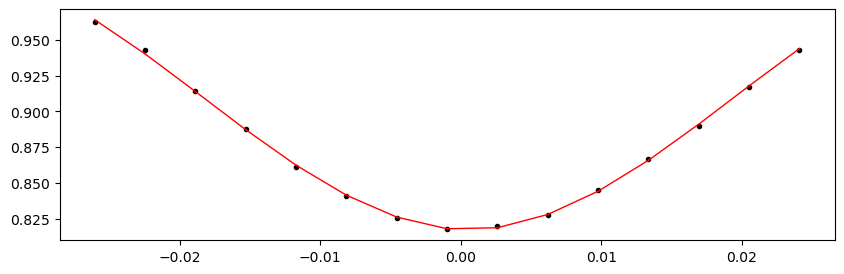

1522.6186276 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.16it/s]


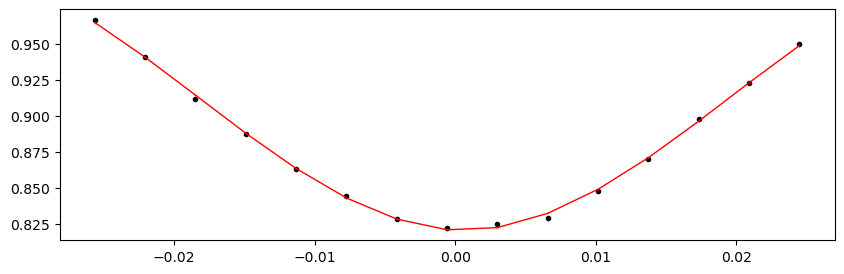

1528.4377207 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.57it/s]


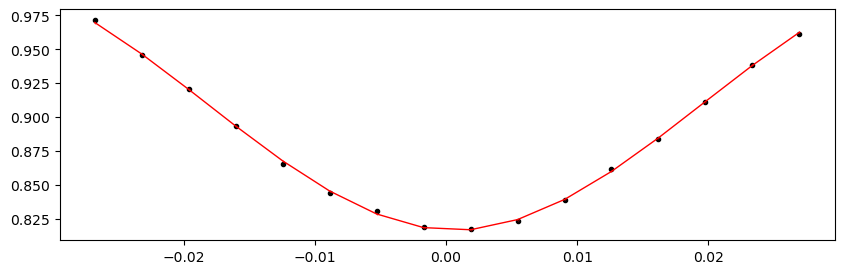

1540.0759069 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.75it/s]


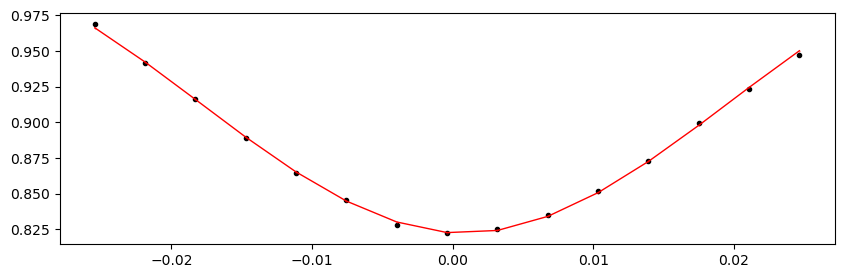

1545.895 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.50it/s]


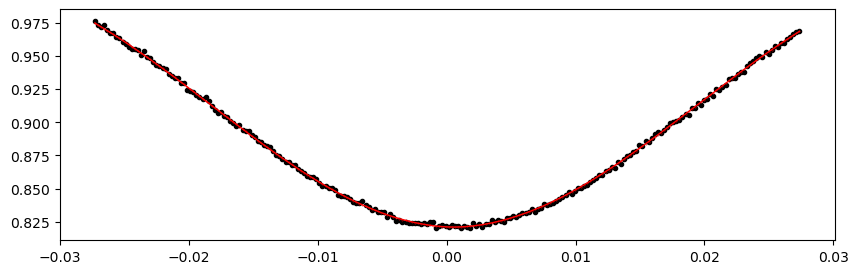

1551.7140931000001 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.56it/s]


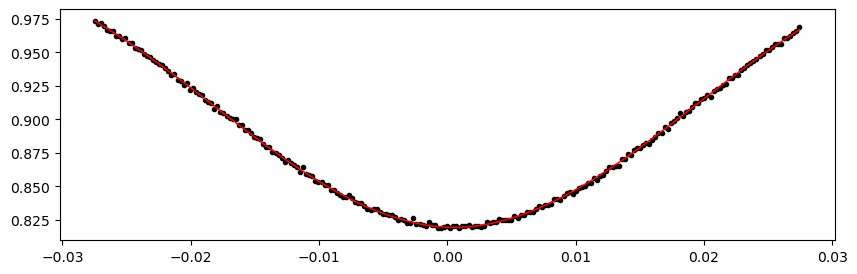

1557.5331862 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.48it/s]


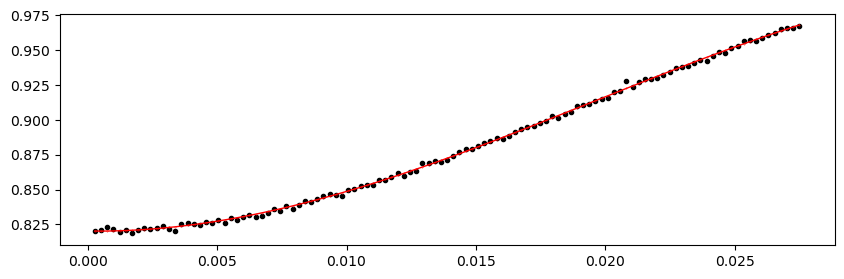

1563.3522793 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.42it/s]


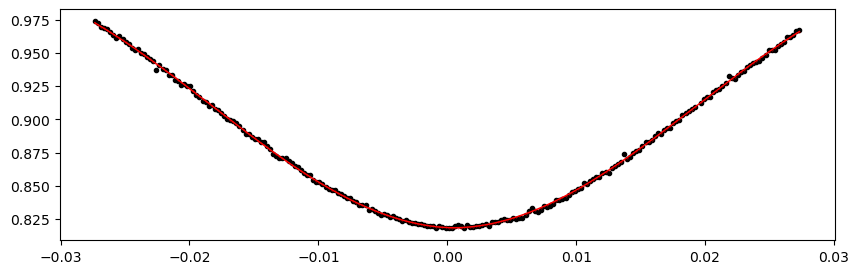

1574.9904655 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.78it/s]


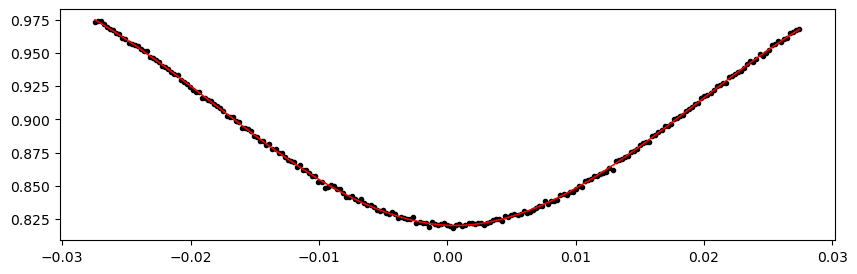

1580.8095586 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.69it/s]


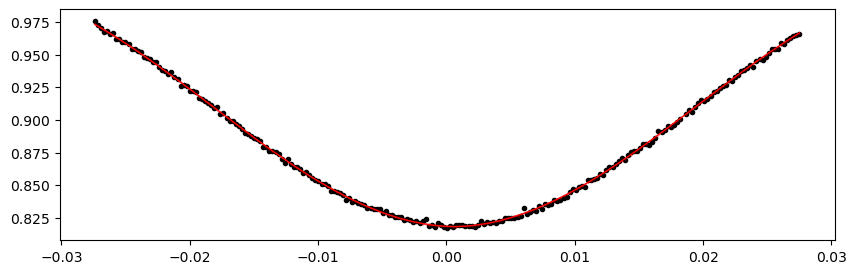

1586.6286517 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.36it/s]


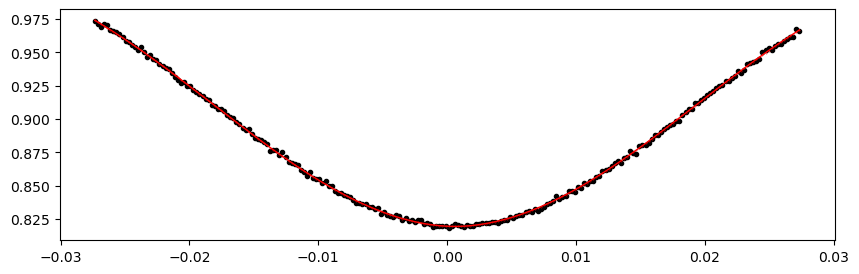

1592.4477448 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.63it/s]


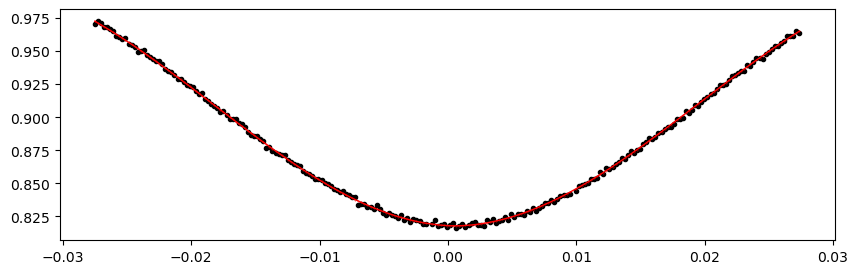

1604.085931 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.15it/s]


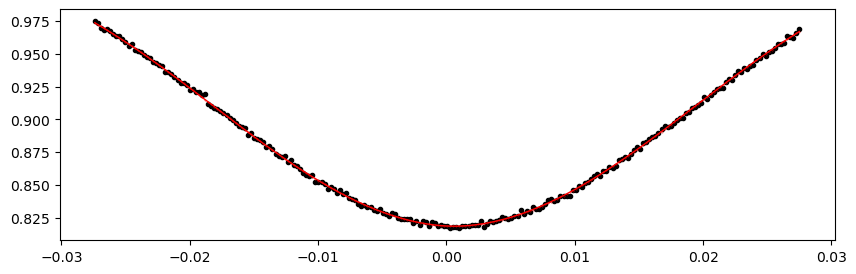

1615.7241172 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.07it/s]


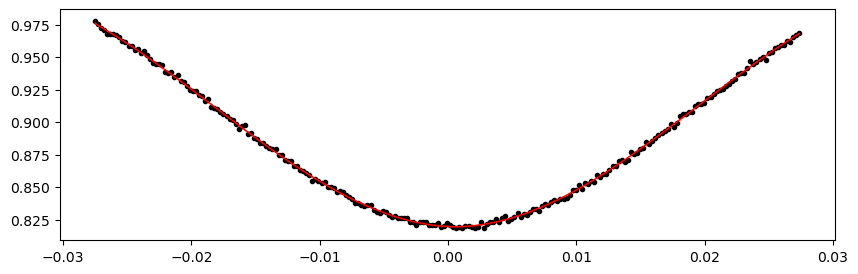

1621.5432103 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.37it/s]


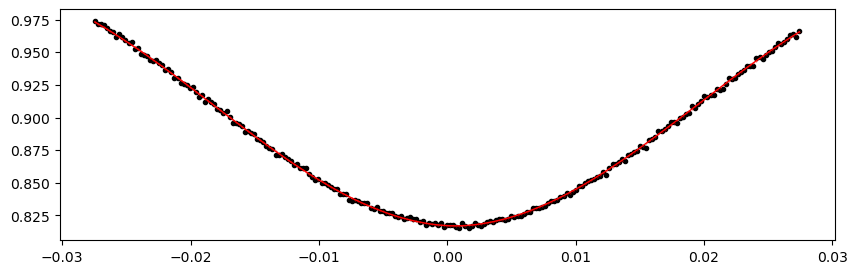

1627.3623034 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.47it/s]


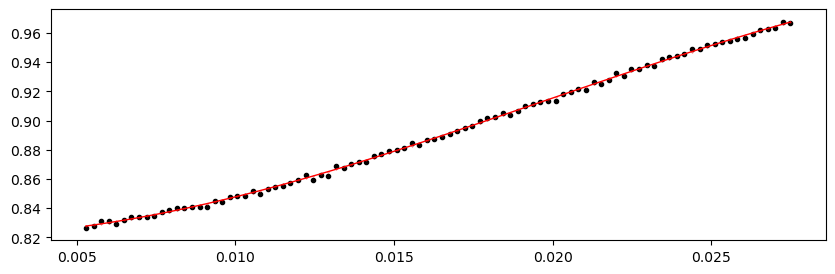

1633.1813965000001 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.73it/s]


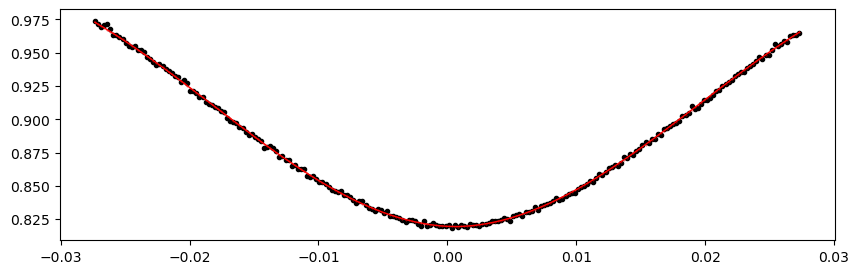

1639.0004896 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.35it/s]


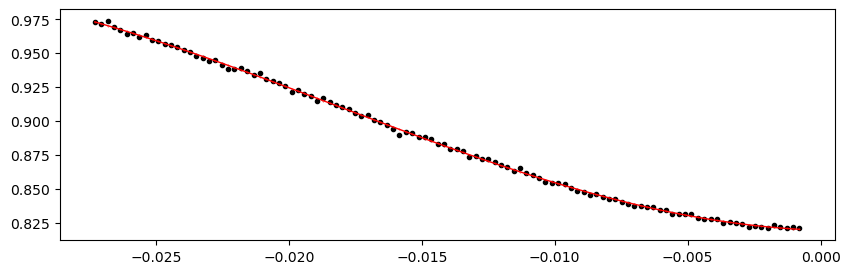

1644.8195827 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.36it/s]


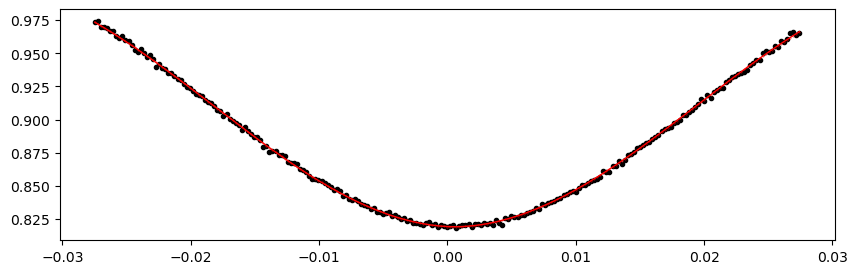

1650.6386758 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.48it/s]


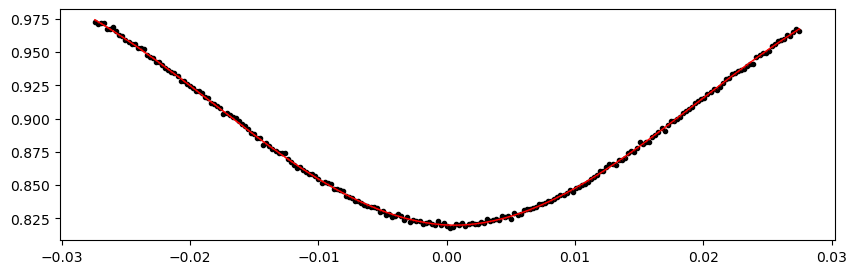

1656.4577689 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.32it/s]


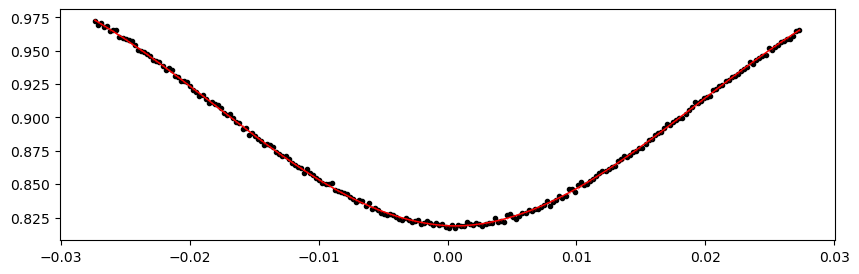

1662.2768620000002 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.95it/s]


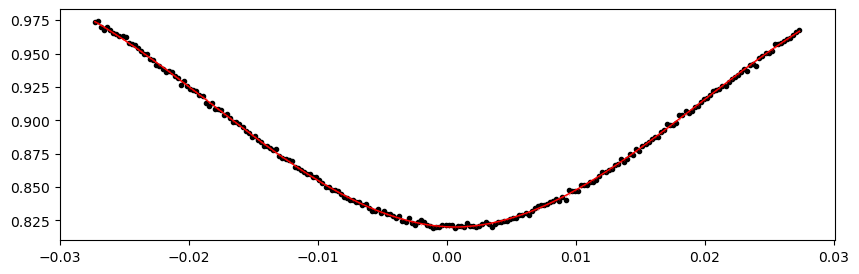

1673.9150482 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 297.66it/s]


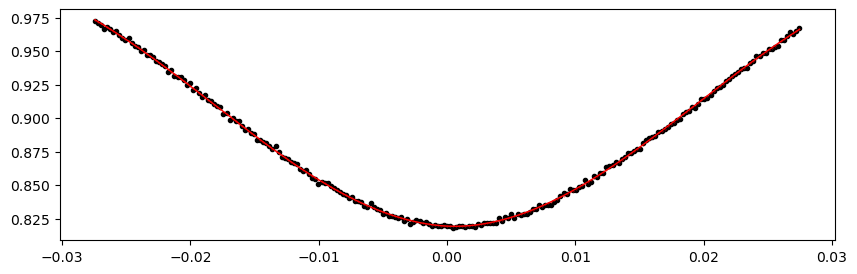

1679.7341413 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.94it/s]


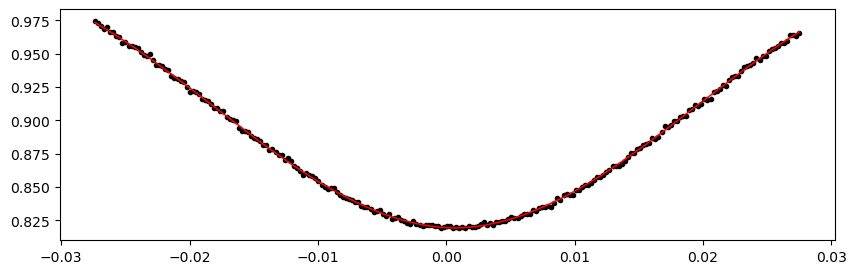

2063.7942859 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.13it/s]


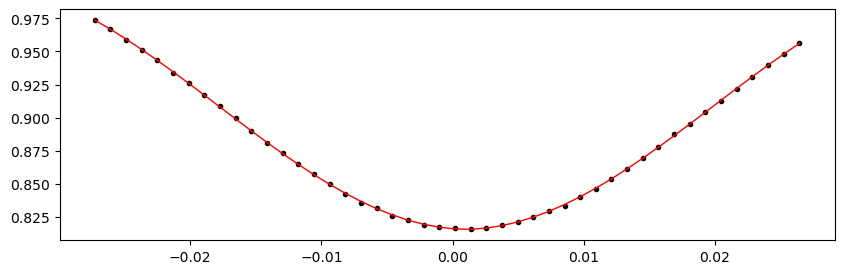

2069.613379 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.60it/s]


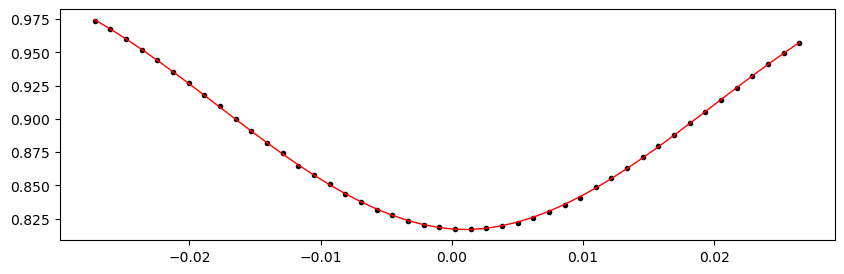

2075.4324721000003 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.45it/s]


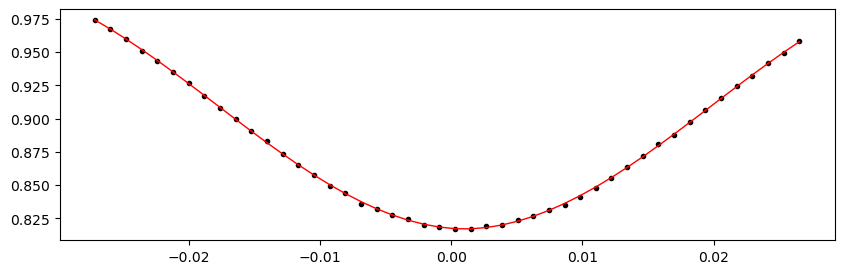

2081.2515652 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.53it/s]


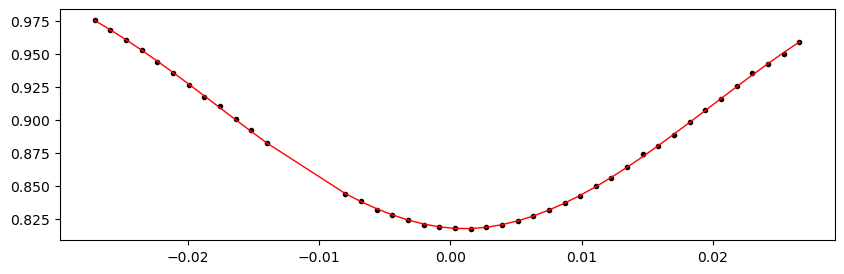

2092.8897514 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.75it/s]


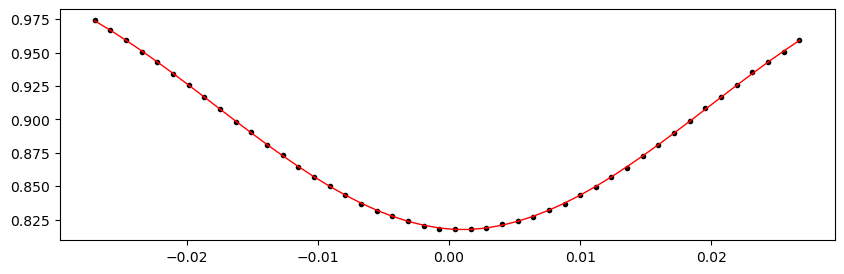

Time 2098.7088445 does not have enough data points: 6
2104.5279376 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.95it/s]


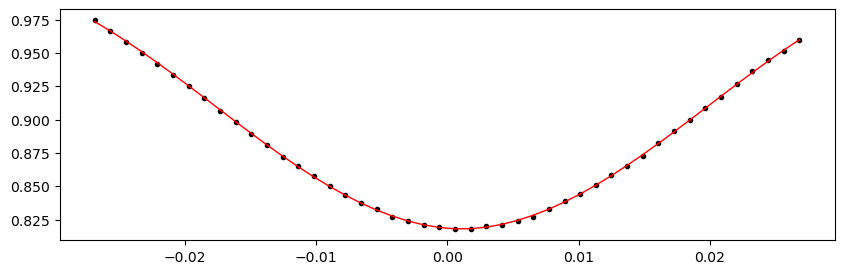

2110.3470307 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.45it/s]


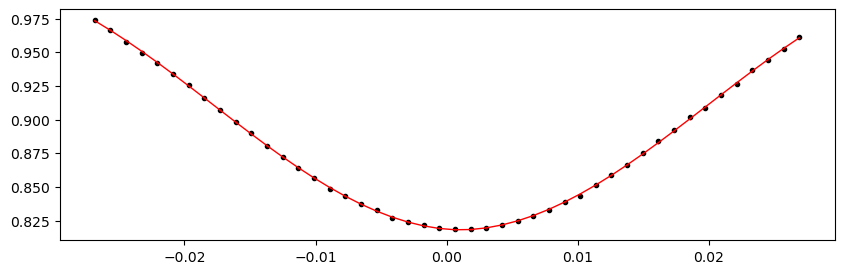

2116.1661238 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.29it/s]


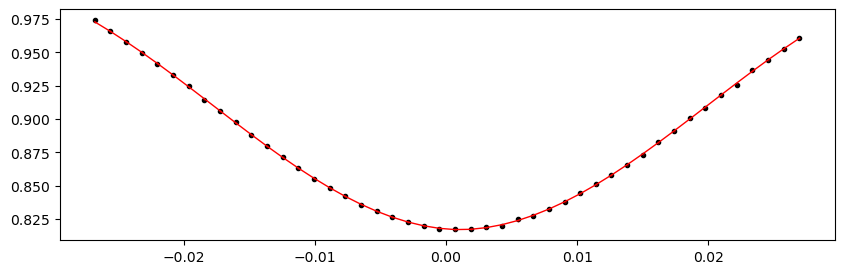

2121.9852169 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.58it/s]


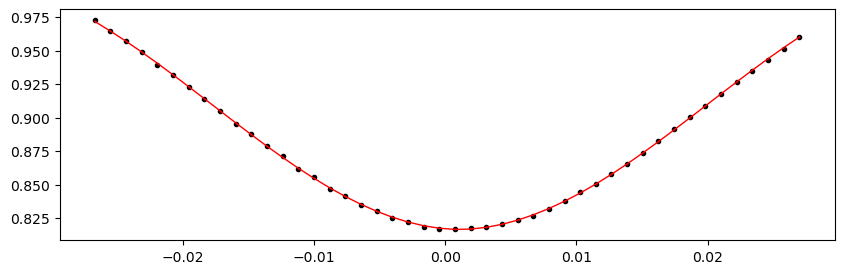

2133.6234031 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.28it/s]


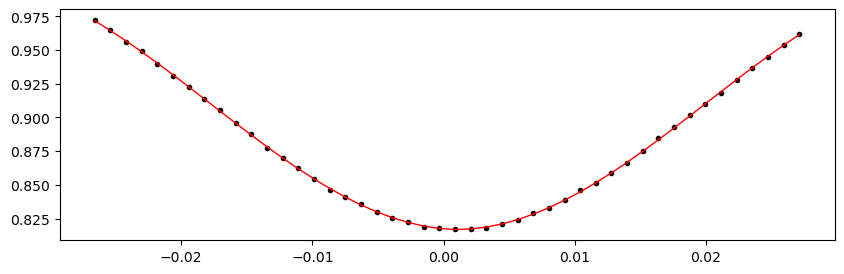

2139.4424962000003 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.74it/s]


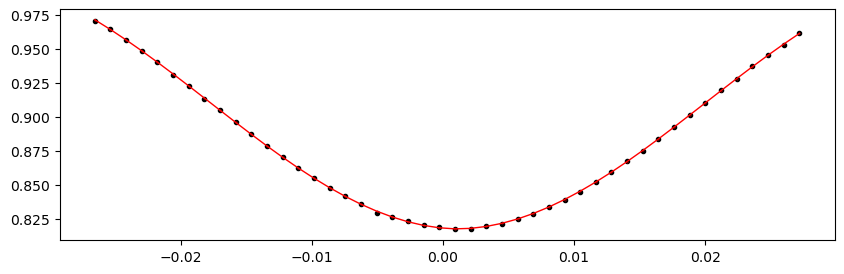

2145.2615893 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.72it/s]


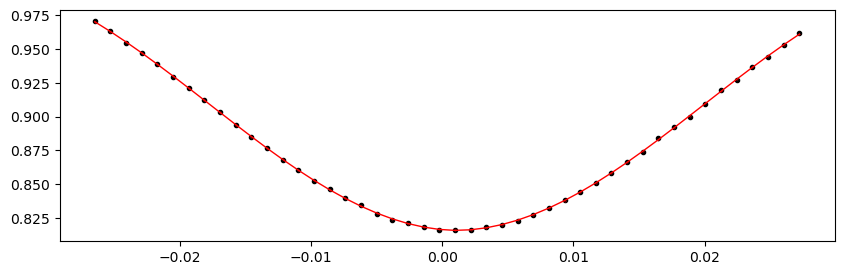

2151.0806824 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.74it/s]


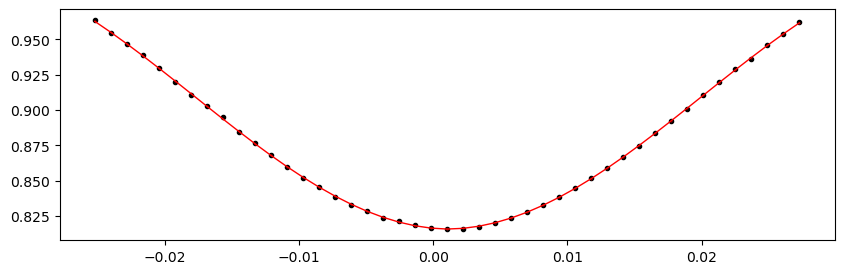

2162.7188686 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.01it/s]


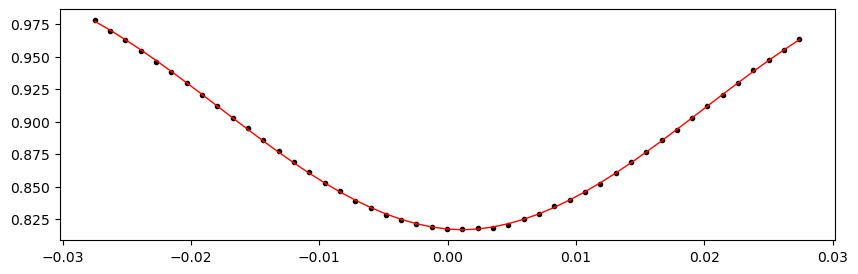

2168.5379617 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.55it/s]


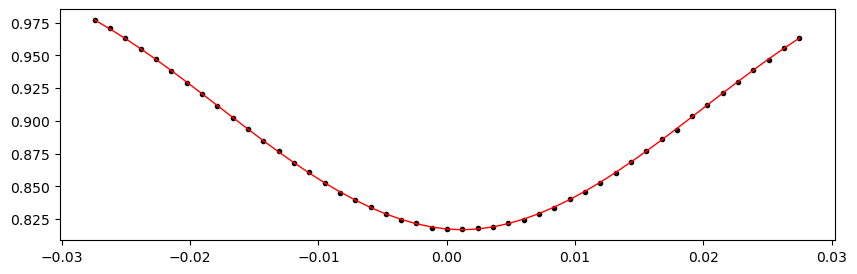

2174.3570548 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.18it/s]


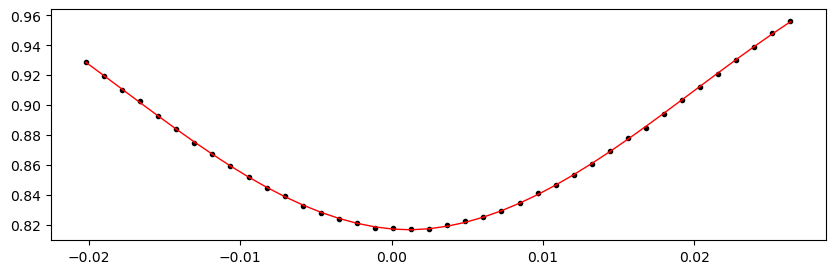

2180.1761479 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.63it/s]


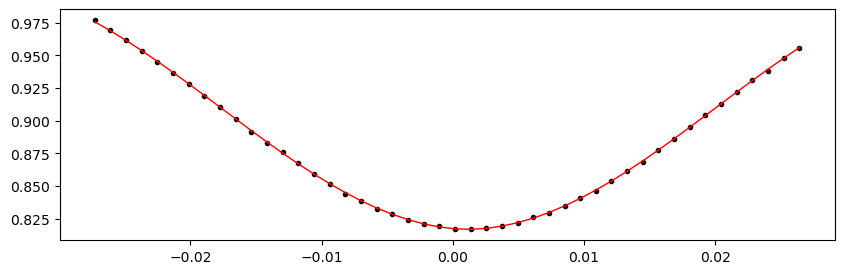

2191.8143341 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.93it/s]


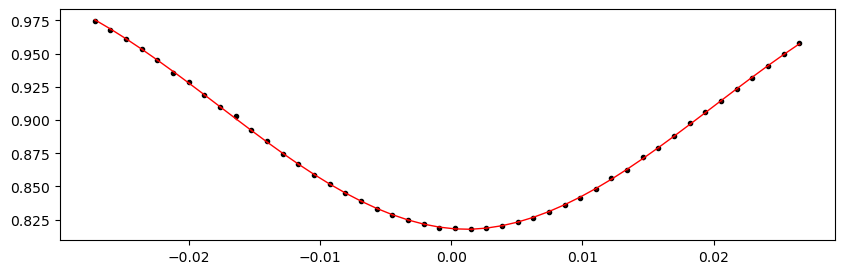

2197.6334272 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.95it/s]


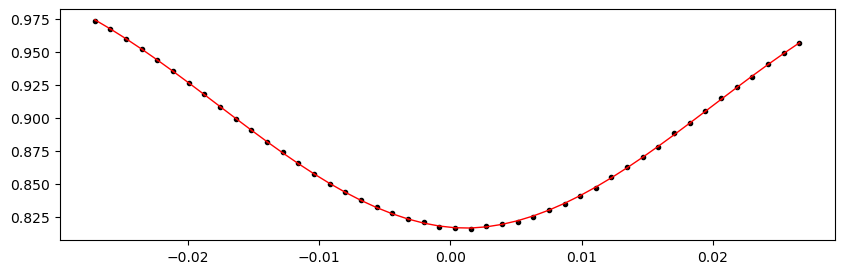

2203.4525203000003 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.28it/s]


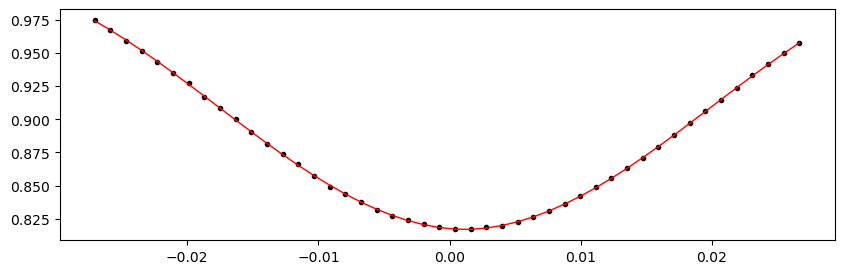

2209.2716134 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.78it/s]


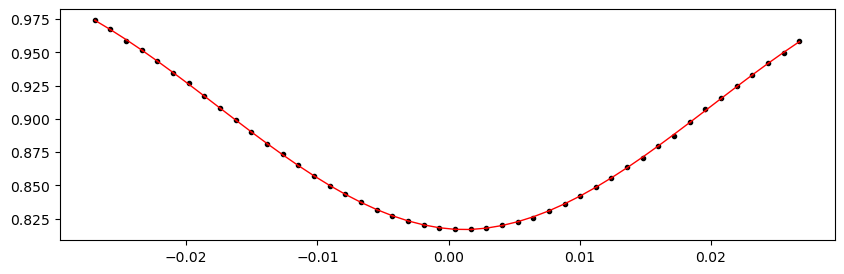

2220.9097996 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.33it/s]


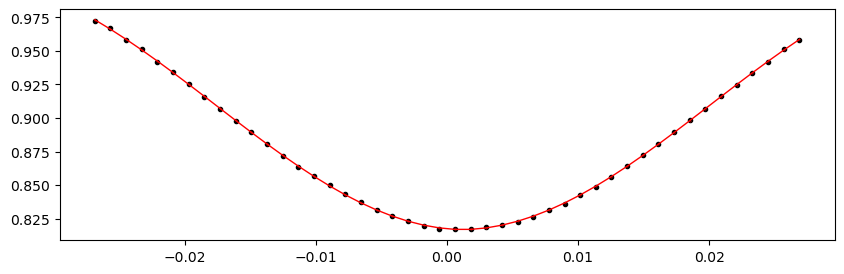

2226.7288927 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.80it/s]


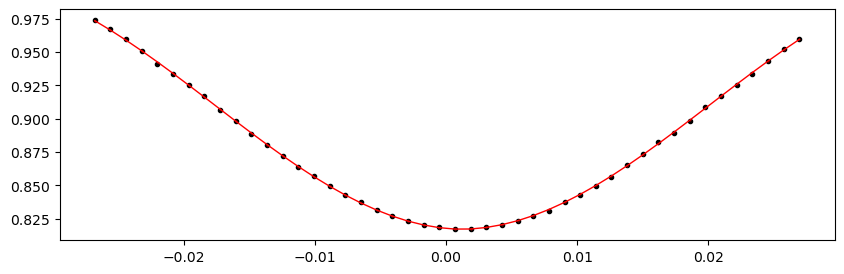

2232.5479858 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.49it/s]


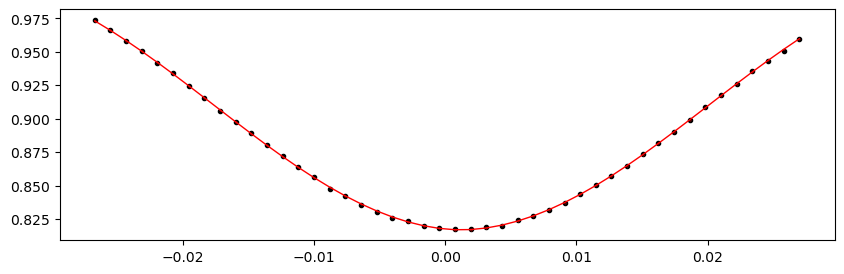

2238.3670789 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.63it/s]


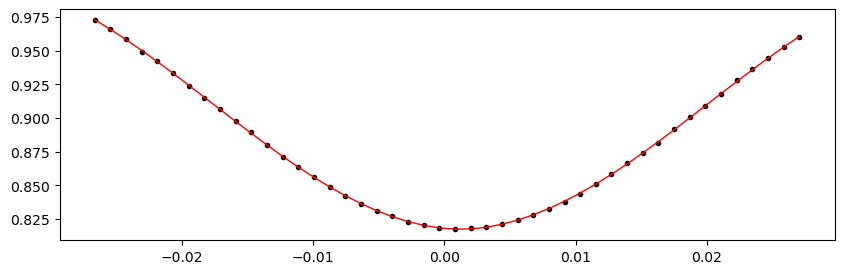

2244.186172 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.09it/s]


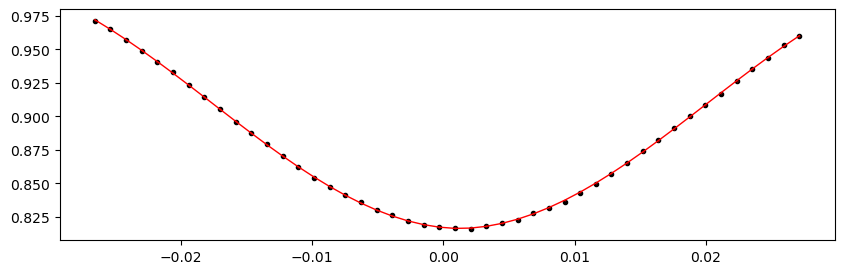

2250.0052651 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.94it/s]


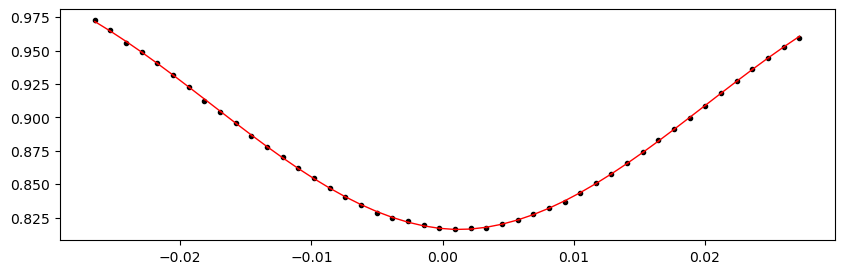

2255.8243582 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.43it/s]


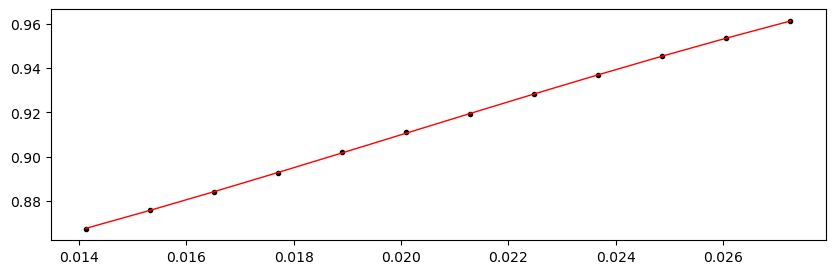

2261.6434513 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.74it/s]


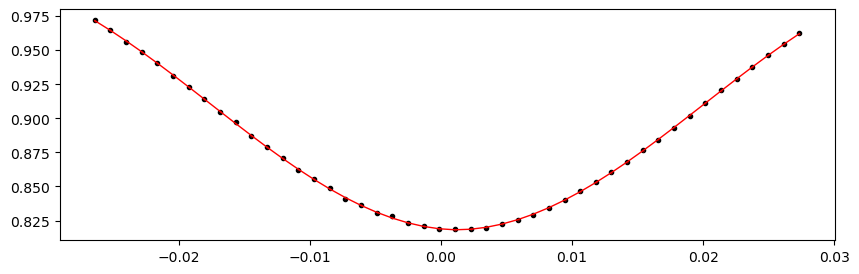

2273.2816375 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.63it/s]


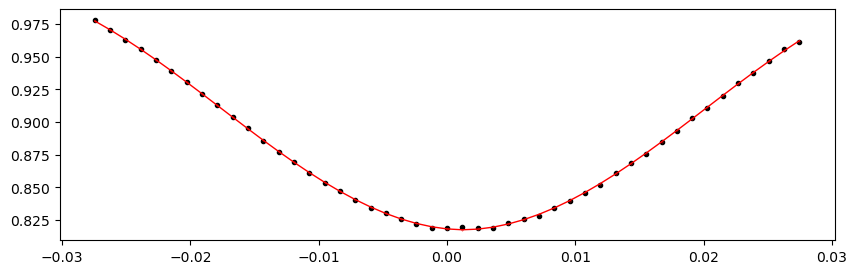

2279.1007306 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.76it/s]


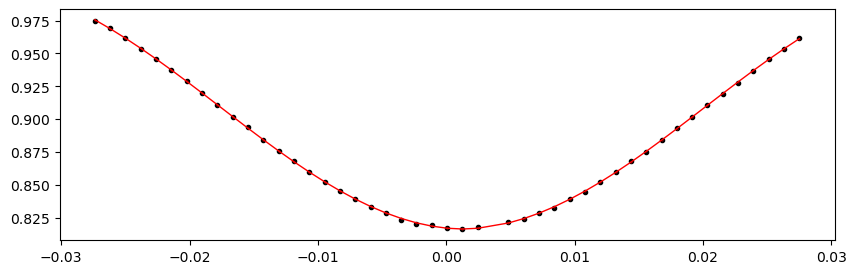

2284.9198237 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.97it/s]


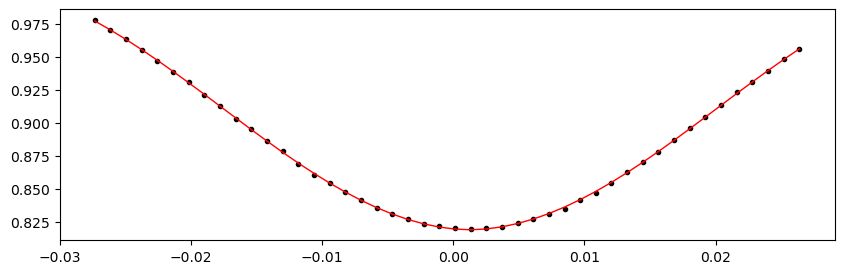

2290.7389168 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.12it/s]


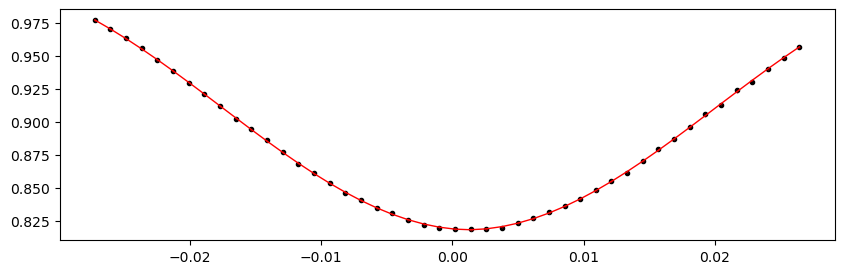

2296.5580099 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.31it/s]


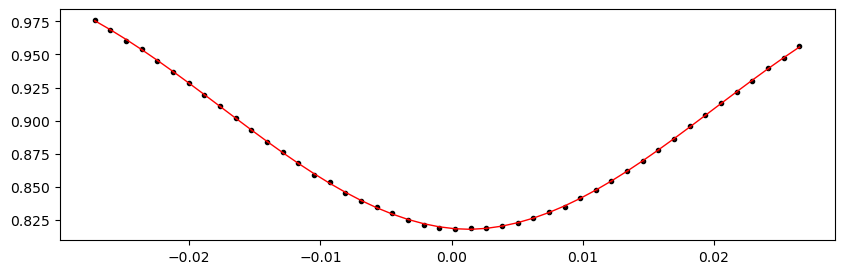

2302.377103 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.38it/s]


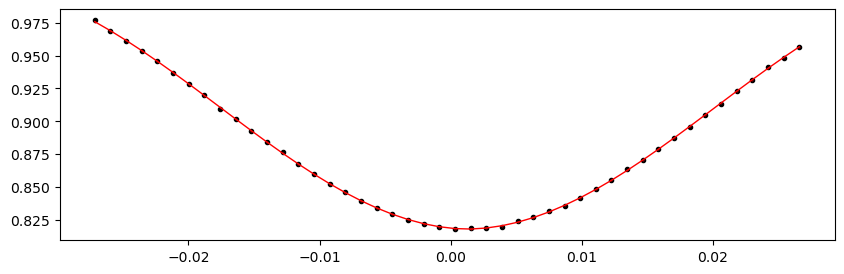

2337.2916616 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.52it/s]


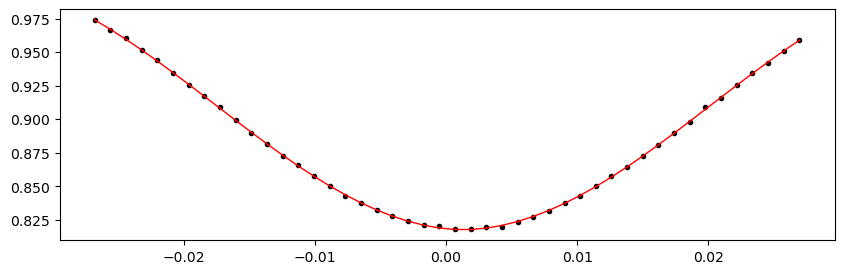

2343.1107547 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.79it/s]


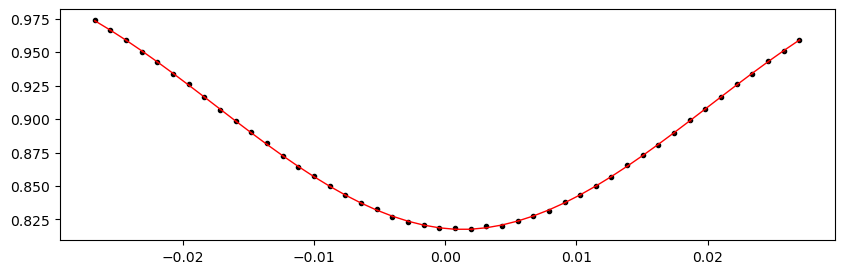

2348.9298478 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.87it/s]


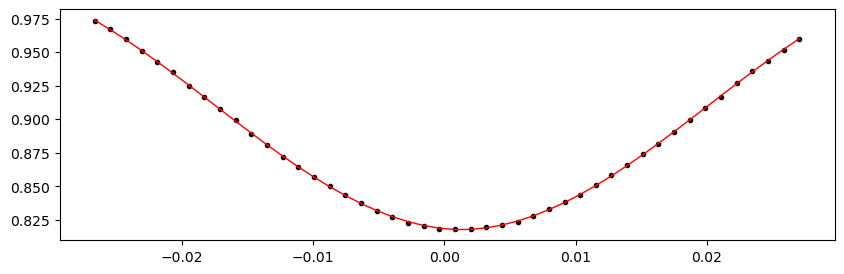

2354.7489409 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.39it/s]


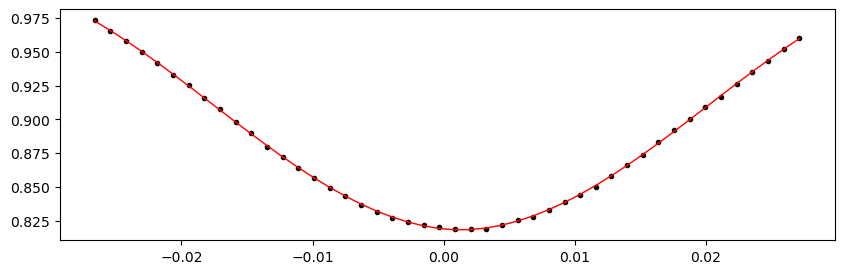

2360.568034 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.93it/s]


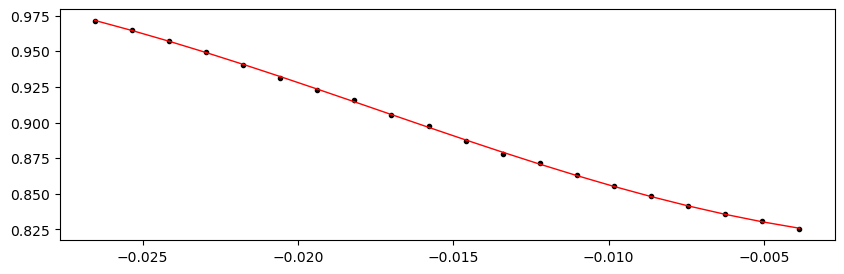

2366.3871271 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.90it/s]


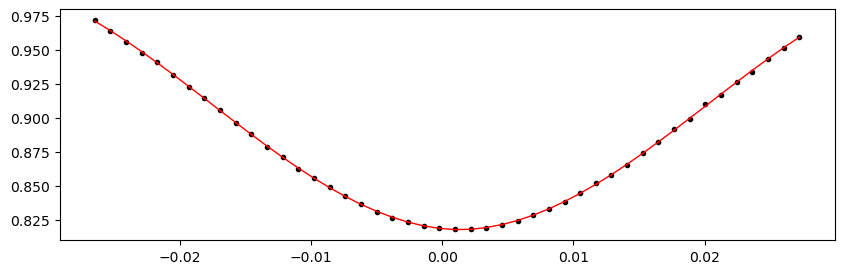

2372.2062201999997 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.80it/s]


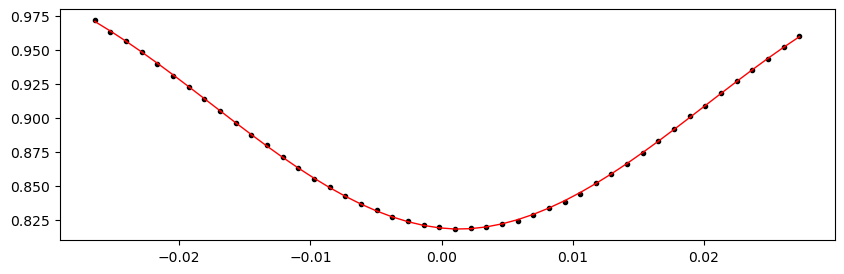

2378.0253133 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.85it/s]


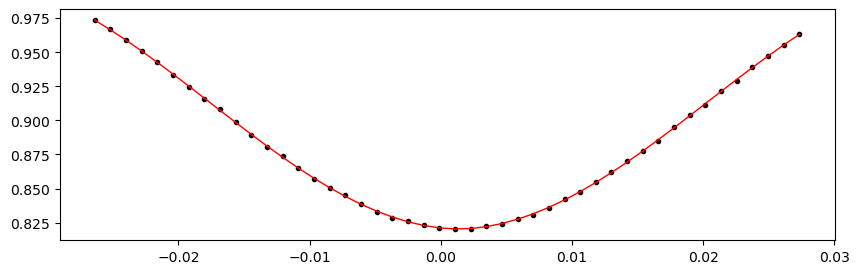

2383.8444064 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.99it/s]


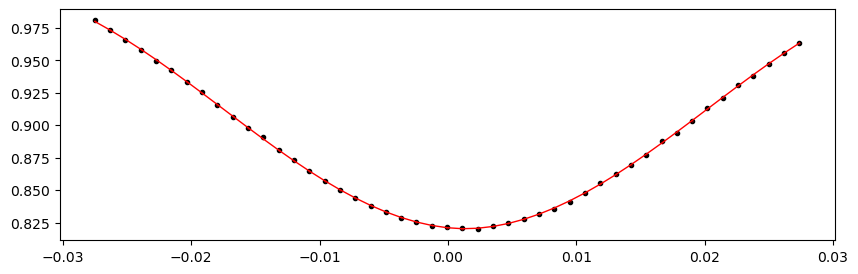

2389.6634995 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.10it/s]


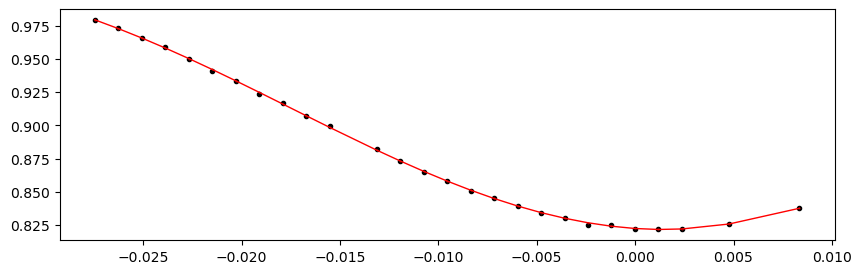

2965.7537164 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 287.60it/s]


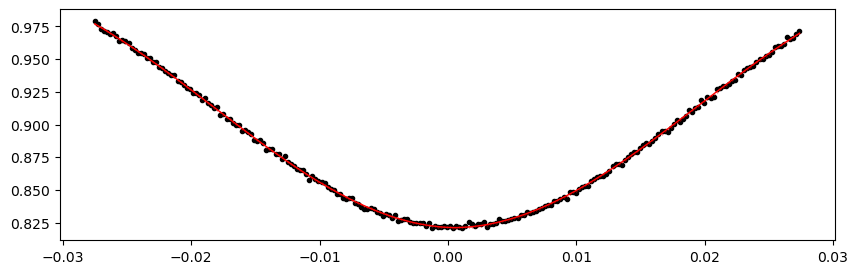

2971.5728095 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.78it/s]


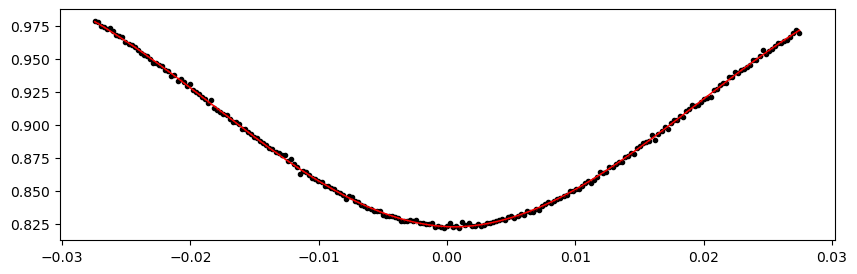

2977.3919026000003 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 289.53it/s]


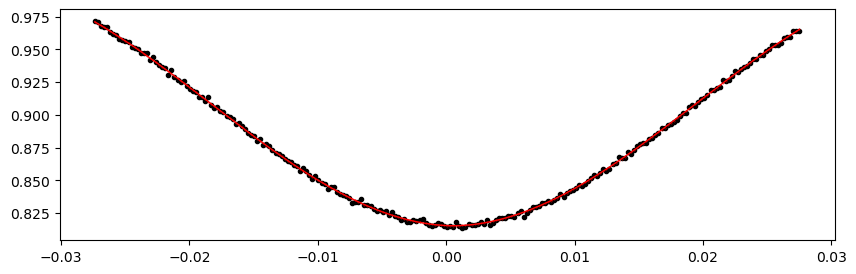

2983.2109957000002 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.15it/s]


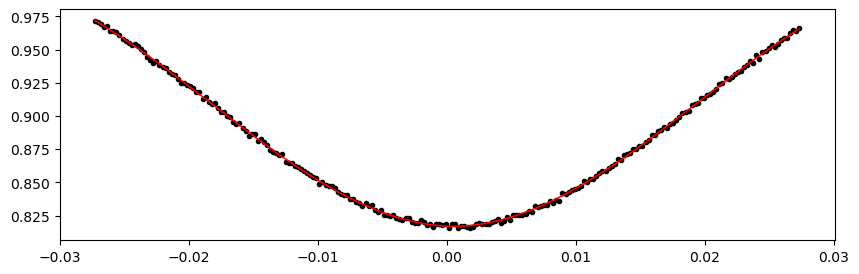

2994.8491819 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.12it/s]


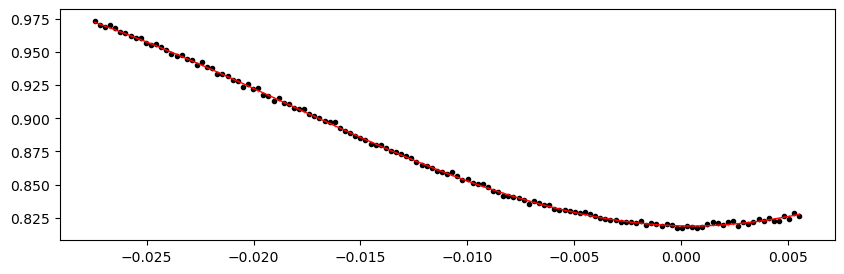

3000.668275 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 294.01it/s]


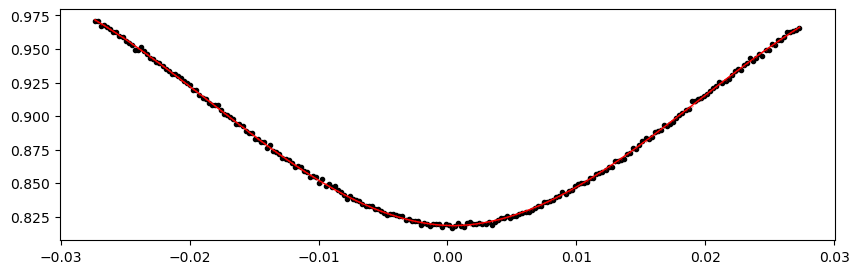

3006.4873681 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.17it/s]


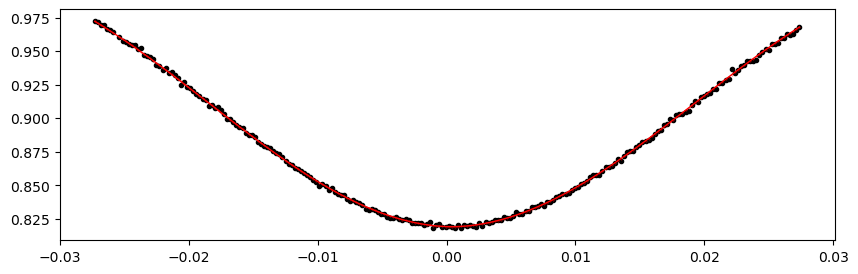

3012.3064612 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.26it/s]


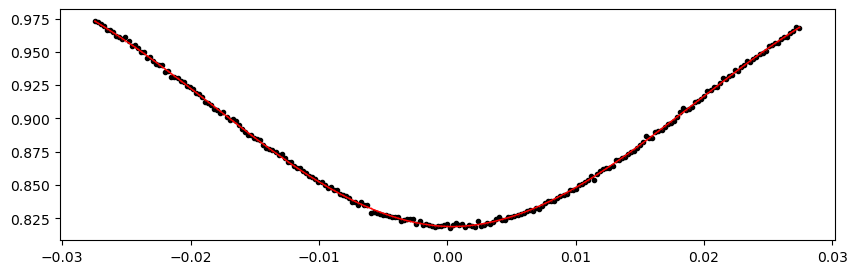

3018.1255542999997 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.15it/s]


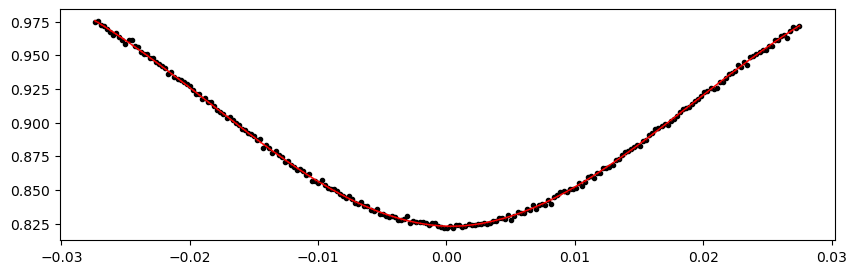

3023.9446474 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.80it/s]


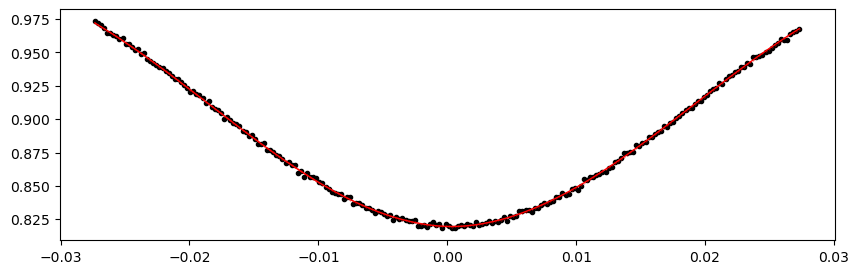

3029.7637405 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.03it/s]


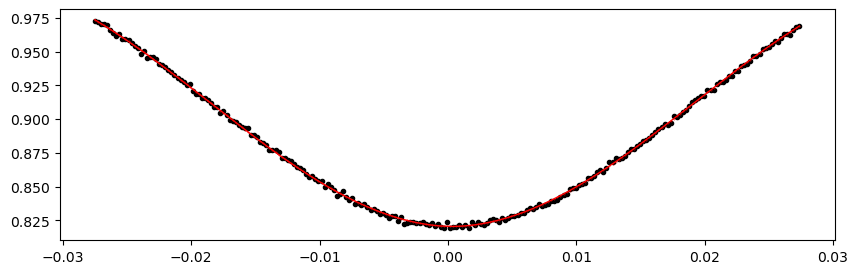

3035.5828336 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.24it/s]


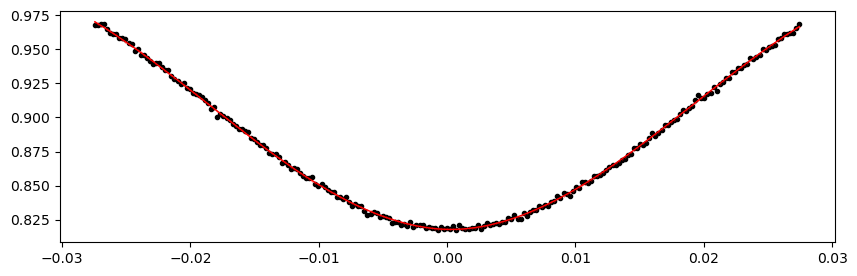

3041.4019267000003 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.65it/s]


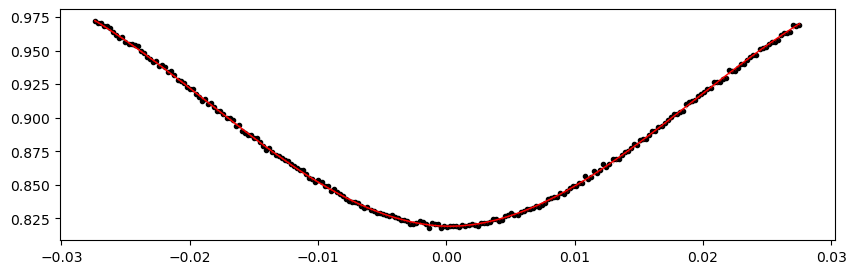

3047.2210198000002 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 286.12it/s]


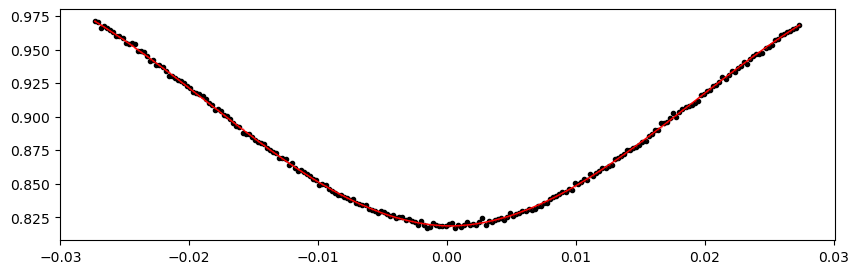

3053.0401129 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.34it/s]


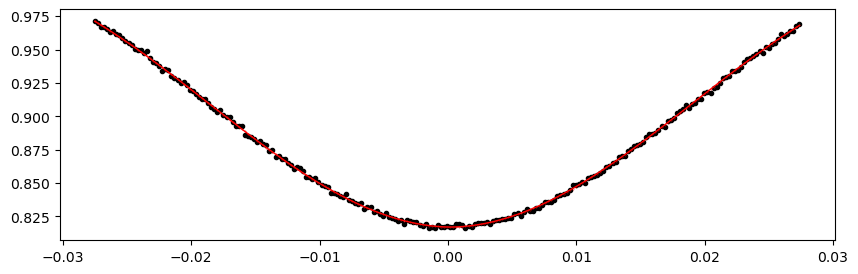

3058.859206 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.75it/s]


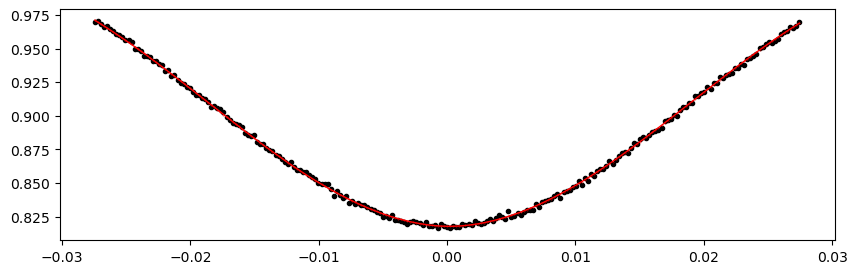

3064.6782991 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.20it/s]


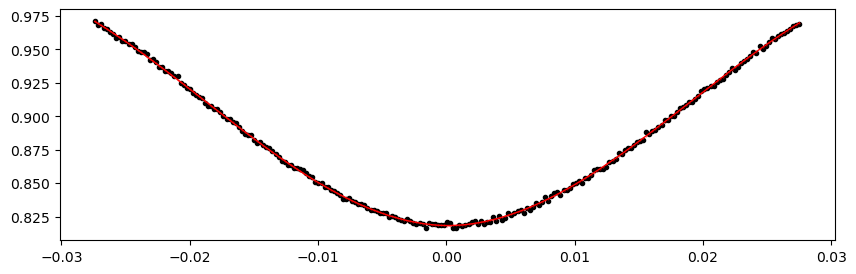

3070.4973922 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.86it/s]


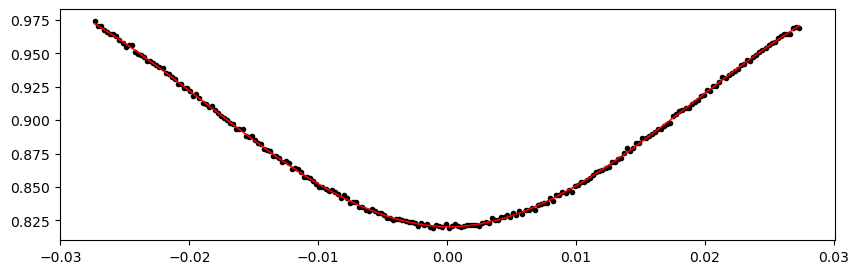

3076.3164853 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.40it/s]


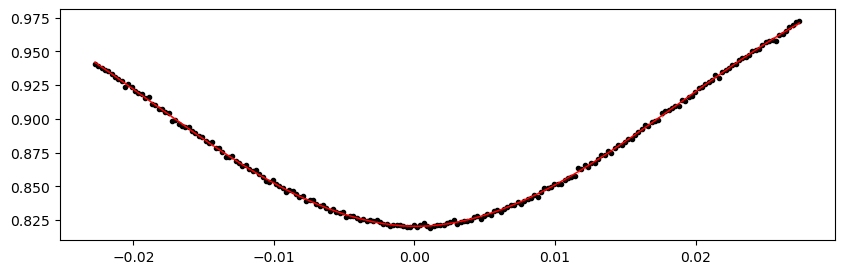

3087.9546715 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.34it/s]


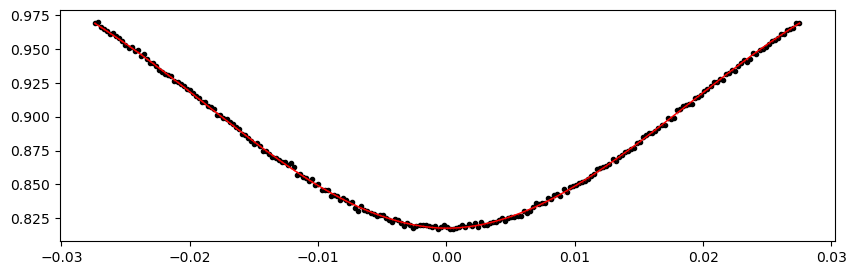

3093.7737646 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 312.22it/s]


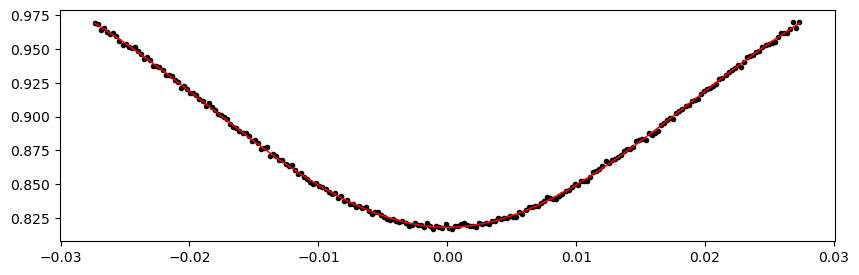

3099.5928577 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.58it/s]


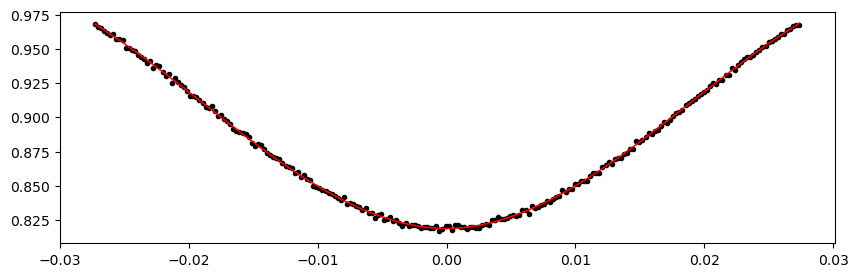

3105.4119508000003 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.39it/s]


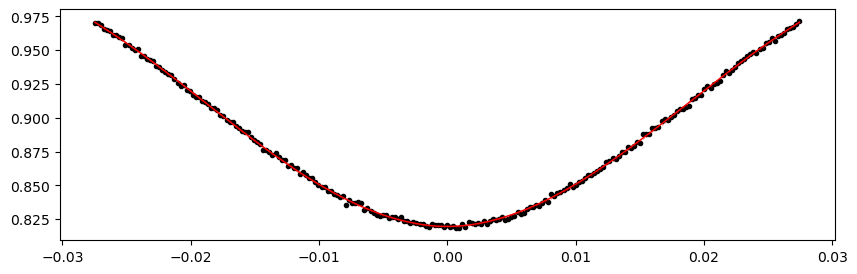

3117.050137 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.66it/s]


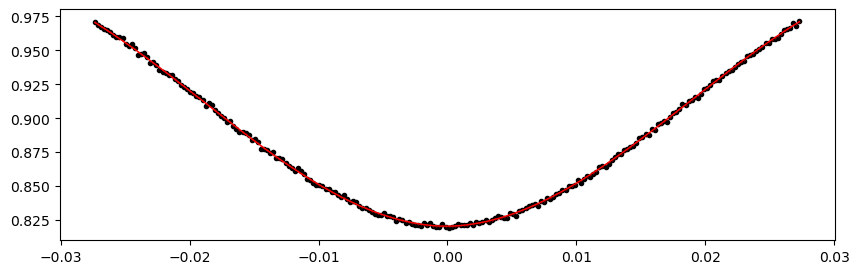

3128.6883232 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.68it/s]


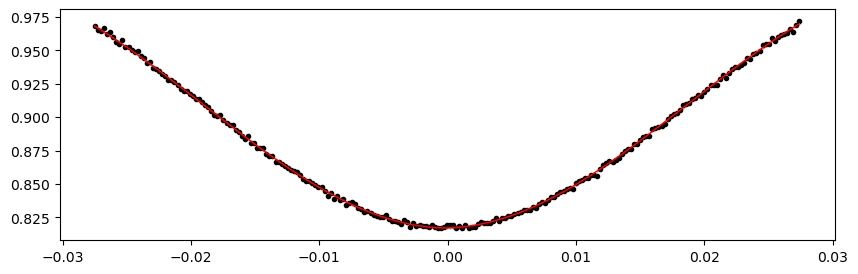

3134.5074163 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.99it/s]


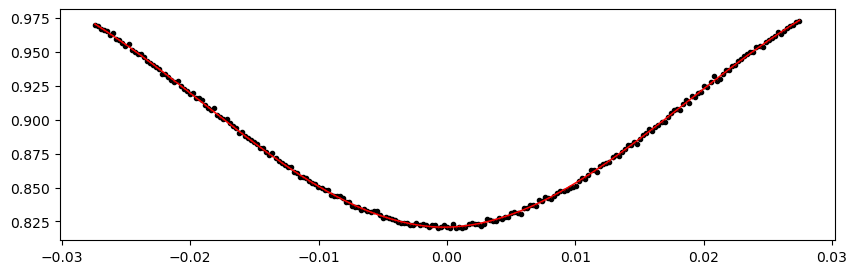

3146.1456024999998 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.69it/s]


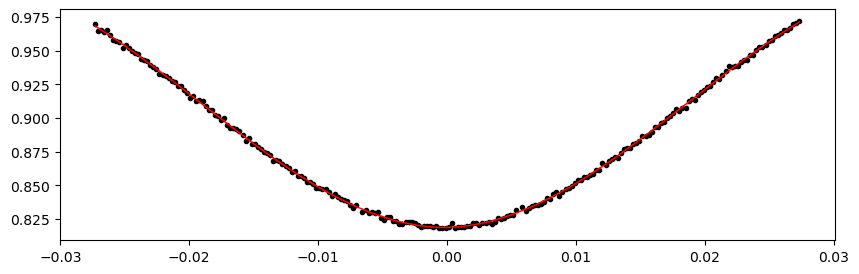

3186.8792542 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 281.85it/s]


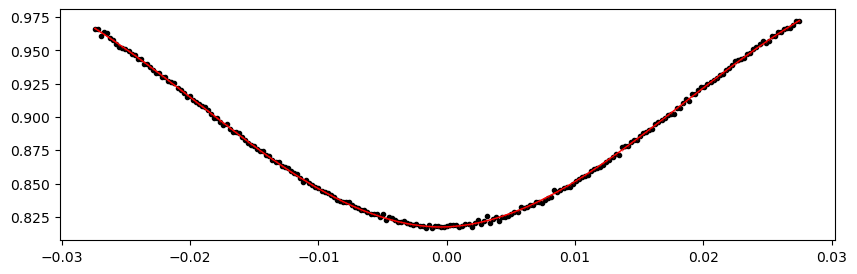

3192.6983473 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.98it/s]


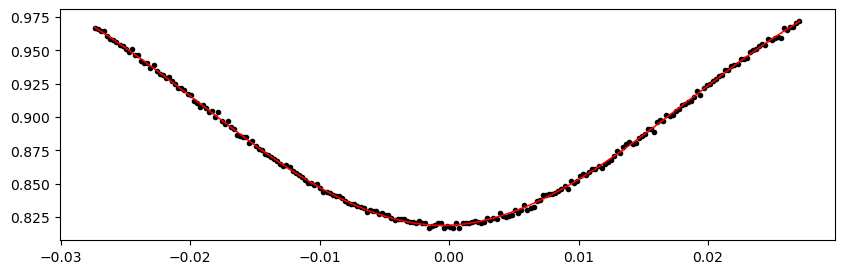

3198.5174404 1.0210124287264306 -0.2023593160141779 -0.3728793304160709


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.98it/s]


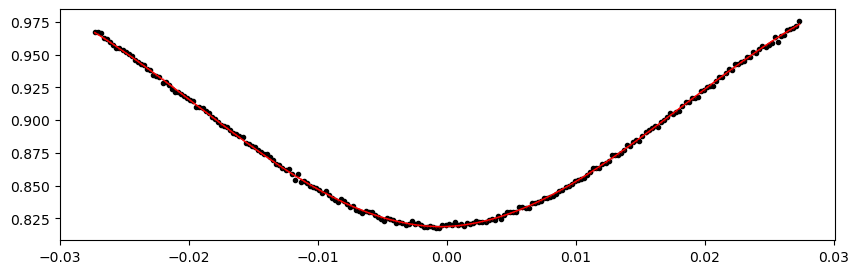

In [20]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=10,  # accomodate 30-min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

Note: 1 data points in df_primary filtered out due to huge O-C error.
Note: 1 data points in in_df_secondary filtered out (outliers).


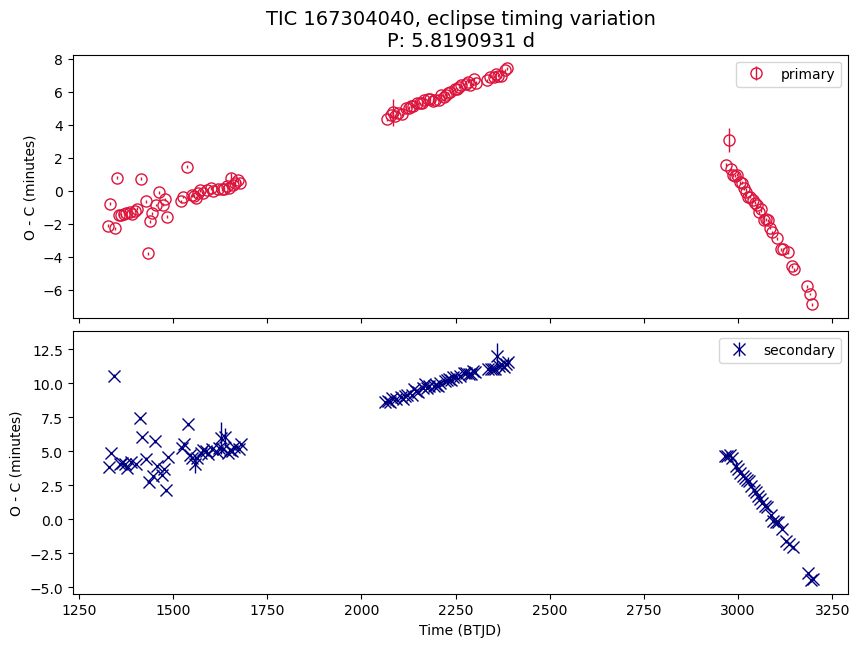

In [26]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 2]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 2]  # filter out outliers in error
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out (outliers).")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### Compare with O-C plot including ingress/egerss in the model

based on clipped lightcurve with 1.2X eclipse duration

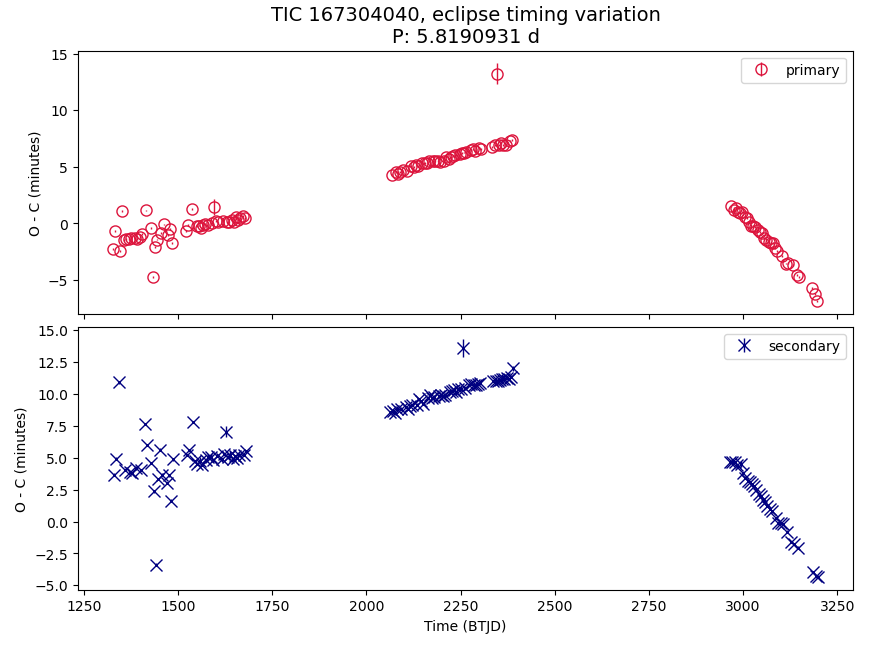

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

In [27]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

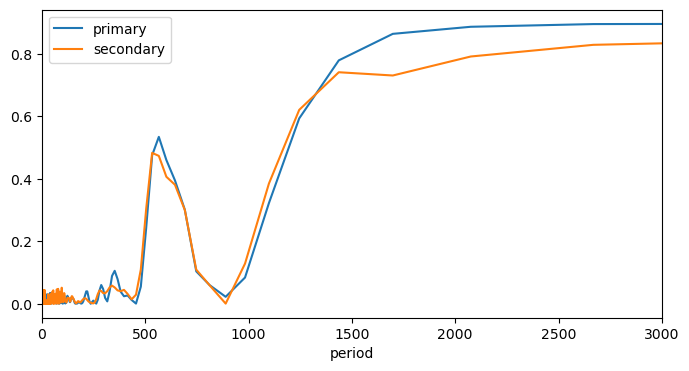

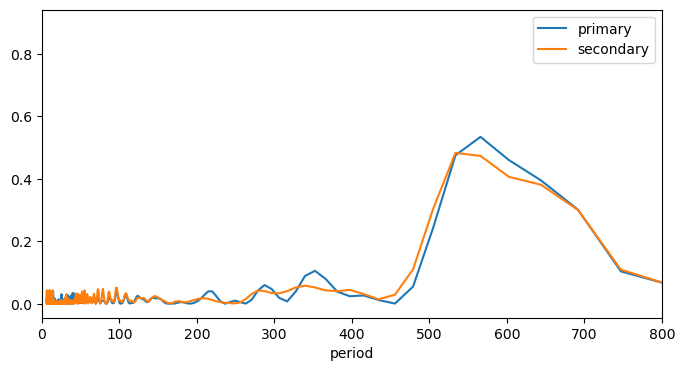

In [33]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
plt.xlim(0, 3000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 800)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [30]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

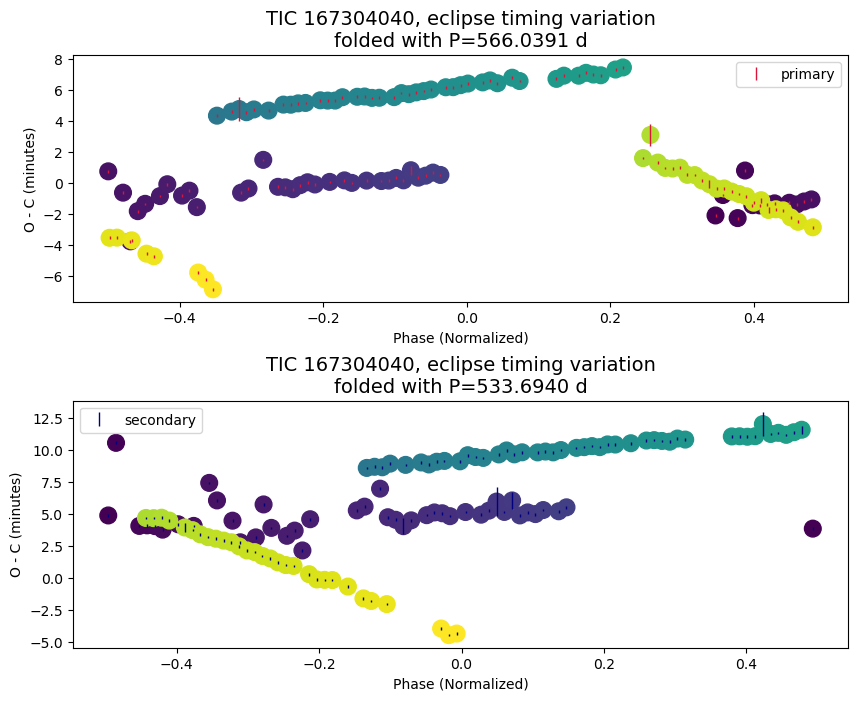

In [32]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=1000,
        period_min_s=None, period_max_s=1000
    )
    tweak_axs(axs)

## Results Summary

In [34]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C suggests long-term (1800+ d) non-linear trend for both primary and secondary eclipses, amplitude > 15 min. [D*0.8]"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

0
tic                                                                                                                       167304040
has_etv                                                                                                                           Y
comments     O-C suggests long-term (1800+ d) non-linear trend for both primary and secondary eclipses, amplitude > 15 min. [D*0.8]
period                                                                                                                     5.819093
depth_pct_p                                                                                                                   21.05
depth_pct_s                                                                                                                   20.24
epoch_p                                                                                                                 1328.074555
epoch_s                                                                                                                 1330.588555
num_sectors                                                                                                                      31
time_span                                                                                                                   1882.79
time_start                                                                                                                  1325.34
time_end                                                                                                                    3208.14


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
167304040,Y,"O-C suggests long-term (1800+ d) non-linear trend for both primary and secondary eclipses, amplitude > 15 min. [D*0.8]",5.8190931,21.05,20.24,1328.0745553000002,1330.5885553,31,1882.79,1325.34,3208.14

